# Final protocol tests

Developped by Alexandre Le Mercier. *This code is under the MIT license as the rest of this package content (cf. the README.md file).*

Please note that importing classes from my package only needs to be done through "from vea import ...". This does not correspond to how libraries are imported in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os
import sys
import tqdm as tq
from tqdm.notebook import tqdm
import warnings
import gc
import xgboost as xg
import lightgbm as lgb
import sklearn as sk
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif
import optuna
import joblib
from joblib import Parallel, delayed

from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from attacks.header import *
from attacks.Attack import Attack
from attacks.HillClimbing import HillClimbing
from attacks.SimulatedAnnealing import SimulatedAnnealing
from attacks.TabuSearch import TabuSearch
from neighborhoods.Neighborhood import Neighborhood
from neighborhoods.Radar import Radar
from master.protocols import *
from master.Master import Master

libraries = [pd, np, sns, tq, xg, lgb, sk, optuna, joblib, sns]

warnings.filterwarnings("ignore")
SEED = 5
np.random.seed(SEED)

# Print Python's version
print(f'Python version: {sys.version}\n')

# Print libraries versions
for lib in libraries:
    print(f'{lib.__name__}: {lib.__version__}')

# Set pandas options
pd.set_option('display.max_columns', 500)

# Print today's date
print("\nLast run: ", date.today())

Python version: 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]

pandas: 2.2.3
numpy: 2.1.3
seaborn: 0.13.2
tqdm: 4.67.0
xgboost: 2.1.2
lightgbm: 4.5.0
sklearn: 1.5.2
optuna: 4.0.0
joblib: 1.4.2
seaborn: 0.13.2

Last run:  2025-01-08


# 1. Import datasets

- MNIST (only 10000 first elements)
- Credit card fraud
- CIC IoT 2023
- N-BaIoT

## 1.1 MNIST

In [2]:
# Load MNIST and with only 10_000 samples
N = 10_000
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X_mnist, y_mnist = mnist["data"][:N], mnist["target"][:N]
del mnist
X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.Series(y_mnist)
le = LabelEncoder()
y_mnist = pd.Series(le.fit_transform(y_mnist))
gc.collect()
# Label encode the target

0

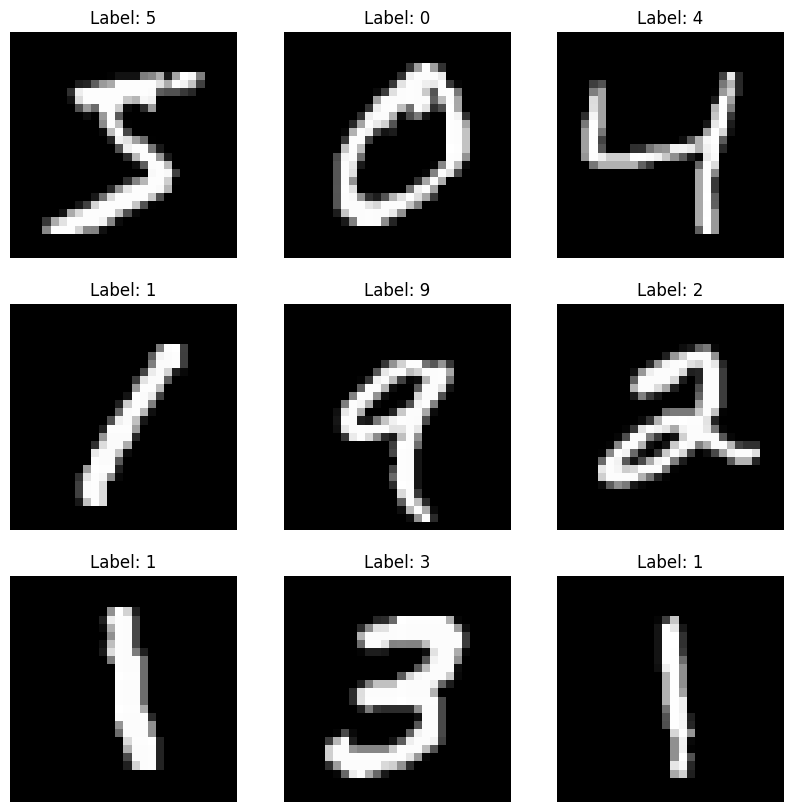

In [3]:
# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_mnist.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist.iloc[i]}')
    plt.axis("off")

## 1.2 Credit Card Fraud

In [2]:
# Import credit card fraud dataset
df = pd.read_csv("../data/card_transdata.csv/card_transdata.csv")
X_credit, y_credit = df.drop('fraud', axis=1), df['fraud']
# Label encode the target
le = LabelEncoder()
y_credit = pd.Series(le.fit_transform(y_credit))
del df
gc.collect()

0

In [3]:
X_credit.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000


In [5]:
# What is the standard deviation of every feature?
X_credit.std()

distance_from_home                65.390784
distance_from_last_transaction    25.843093
ratio_to_median_purchase_price     2.799589
repeat_retailer                    0.323157
used_chip                          0.477095
used_pin_number                    0.300809
online_order                       0.476796
dtype: float64

In [6]:
# Mean
X_credit.mean()

distance_from_home                26.628792
distance_from_last_transaction     5.036519
ratio_to_median_purchase_price     1.824182
repeat_retailer                    0.881536
used_chip                          0.350399
used_pin_number                    0.100608
online_order                       0.650552
dtype: float64

## 1.3 CIC IoT 2023

574

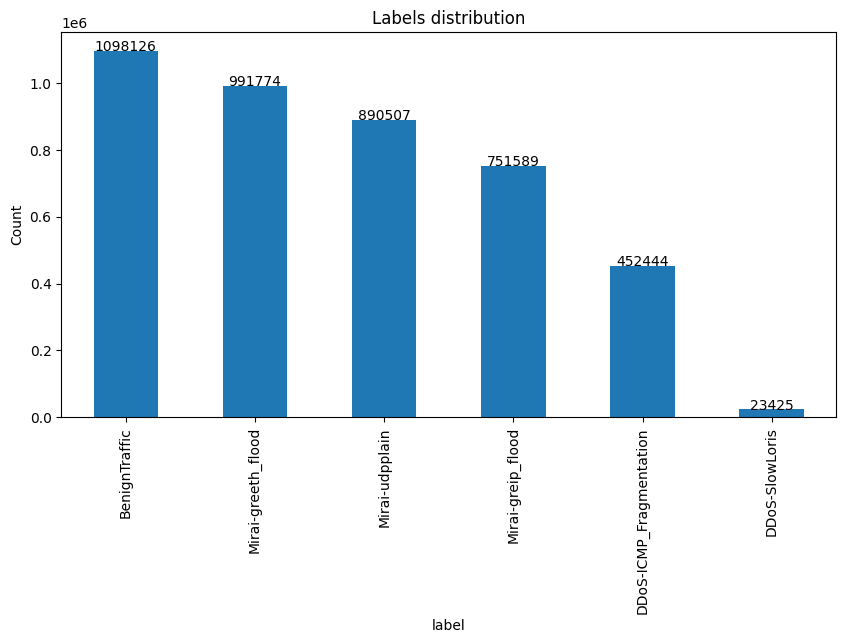

In [3]:
# Import CICIoT23 dataset
df = pd.read_csv("../data/CICIoT23/merged_data_cic.csv")
# Remove values with infinite values in the row
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
# Remove features that are not immediately retrievable (if we identify an attack when it happens, we can't use it to predict it)
df = df.drop(columns=['Number', 'Tot sum', 'Min', 'Max', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'Tot size', 'Protocol Type'])
# Separate the dataset into features and target
X_iot, y_iot = df.drop('label', axis=1), df['label']
# Histogram of labels distribution using matplotlib, ordered in decreasing order and with each bar value indicated
plt.figure(figsize=(10, 5))
plt.title("Labels distribution")
plt.xlabel("Label")
plt.ylabel("Count")
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
# Label encode the target (and keep track of the mapping)
le = LabelEncoder()
y_iot = pd.Series(le.fit_transform(y_iot))
mapping = dict(zip(le.classes_, range(len(le.classes_))))
for i, v in enumerate(df['label'].value_counts().sort_values(ascending=False)):
    plt.text(i, v + 10, str(v), ha='center')
del df
gc.collect()

In [7]:
# Here, we apply quantile transformation to the dataset to make it more Gaussian-like
transformer = QuantileTransformer(output_distribution='normal', random_state=SEED)
X_iot_quant = pd.DataFrame(transformer.fit_transform(X_iot), columns=X_iot.columns)
X_iot_quant.describe()

,Header_Length,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IGMP,IPv,LLC,AVG,Std,IAT,Variance
count,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06,4.207865e+06
mean,-1.066755e+00,7.513918e-03,1.341038e-02,-4.725553e+00,-4.199333e+00,-5.039053e+00,-3.309414e+00,-2.047358e+00,-5.183657e+00,-5.189946e+00,-4.613536e+00,-2.581365e+00,-4.060351e+00,-5.199338e+00,-5.199241e+00,-5.132397e+00,-5.192986e+00,-1.908598e+00,-1.610826e+00,-5.082440e+00,-3.518227e+00,-3.770543e+00,-5.180561e+00,3.518227e+00,3.518227e+00,5.045099e-03,-1.199231e+00,-1.276622e-02,-1.199256e+00
std,2.555566e+00,9.677272e-01,1.002298e+00,1.779001e+00,2.404255e+00,1.097258e+00,2.919278e+00,3.630996e+00,3.613233e-01,3.013037e-01,2.011373e+00,3.482456e+00,2.517159e+00,4.529710e-14,3.165756e-02,7.277789e-01,2.404160e-01,3.633479e+00,3.686875e+00,9.405920e-01,2.838703e+00,2.802591e+00,3.960427e-01,2.838703e+00,2.838703e+00,9.956466e-01,2.650864e+00,1.000749e+00,2.650823e+00
min,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00
25%,-5.199338e+00,-2.979180e-01,-6.610617e-01,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-8.480747e-01,-8.480747e-01,-6.456307e-01,-5.199338e+00,-6.849143e-01,-5.199338e+00
50%,-1.380069e-02,-2.979180e-01,1.315986e-02,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,2.509401e-02,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,5.199338e+00,5.199338e+00,1.631012e-02,-2.218850e-02,-1.126416e-02,-2.219098e-02
75%,6.502736e-01,6.653072e-01,6.852803e-01,-5.199338e+00,-5.199338e+00,-5.199338e+00,6.317848e-01,6.564859e-01,-5.199338e+00,-5.199338e+00,-5.199338e+00,6.518243e-01,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,6.487244e-01,6.831778e-01,-5.199338e+00,8.480747e-01,-5.199338e+00,-5.199338e+00,5.199338e+00,5.199338e+00,6.195782e-01,6.504382e-01,6.602897e-01,6.504265e-01
max,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,-5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00


In [4]:
print(mapping)

{'BenignTraffic': 0, 'DDoS-ICMP_Fragmentation': 1, 'DDoS-SlowLoris': 2, 'Mirai-greeth_flood': 3, 'Mirai-greip_flood': 4, 'Mirai-udpplain': 5}


## 1.4 N-BaIoT

In [16]:
big_df = pd.read_csv("../data/N-BaIoT/merged_dataset.csv")

2922

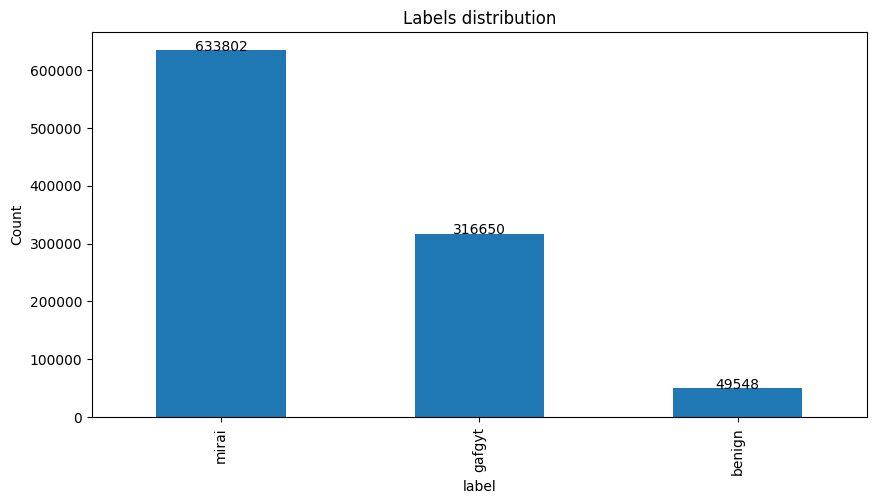

In [17]:
df = big_df[:1_000_000]
# Remove features that are not rapidly retrievable (if we identify an attack when it happens, we can't use it to predict it)
for col in df.columns:
    if 'L5' not in col and col != 'label':
        df = df.drop(col, axis=1)
# Histogram of labels distribution using matplotlib, ordered in decreasing order and with each bar value indicated
plt.figure(figsize=(10, 5))
plt.title("Labels distribution")
plt.xlabel("Label")
plt.ylabel("Count")
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
for i, v in enumerate(df['label'].value_counts().sort_values(ascending=False)):
    plt.text(i, v + 10, str(v), ha='center')
X_baiot, y_baiot = df.drop('label', axis=1), df['label']
le = LabelEncoder()
y_baiot = pd.Series(le.fit_transform(y_baiot))
mapping2 = dict(zip(le.classes_, range(len(le.classes_))))
del df, big_df
gc.collect()

In [18]:
print(mapping2)

{'benign': 0, 'gafgyt': 1, 'mirai': 2}


# 2. Training models

For each dataset:
1. X_mnist, y_mnist
2. X_credit, y_credit
3. X_iot, y_iot
4. X_baiot, y_baiot

Train, without further preprocessing, the following models:
1. XGBClassifier
2. LGBMClassifier
3. HistogramGradientBoostingClassifier
4. ExtraTreesClassifier

Train, with prior feature scaling, the following models:

5. KNNeighborsClassifier
6. RidgeClassifier
7. SVC (limited to N first samples due to large execution time)
8. PassiveAggressiveClassifier
9. LinearDiscriminantAnalysis

... and collect and print accuracy and f1-score.

In [12]:
# Datasets
datasets = {
    "ccf": (X_credit, y_credit),
    "mnist": (X_mnist, y_mnist),
    "cic": (X_iot, y_iot),
    "nbiot": (X_baiot, y_baiot),
}

# Models to train without preprocessing
no_scaling_models = {
    "XGBClassifier": XGBClassifier(random_state=SEED),
    "LGBMClassifier": LGBMClassifier(random_state=SEED, verbose=-1),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=SEED),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=SEED),
}

# Models to train with feature scaling
scaling_models = {
    #"KNeighborsClassifier": KNeighborsClassifier(), # KNN takes too much time on testing
    "RidgeClassifier": RidgeClassifier(random_state=SEED),
    "SVC": SVC(random_state=SEED),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(random_state=SEED),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
}

limit_svc = {
    "ccf": 10000,
    "mnist": 10000,
    "cic": 10000,
    "nbiot": 10000,
}

# Results storage
results = []

# Directory to save the models
model_save_path = "../trained_models"
os.makedirs(model_save_path, exist_ok=True)

for dataset_name, (X, y) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

    # Train models without scaling
    for model_name, model in no_scaling_models.items():
        model_path = os.path.join(model_save_path, f"{dataset_name}_{model_name}.joblib")
        if os.path.exists(model_path):
            print(f"Loading saved model for {dataset_name} - {model_name}")
            model = joblib.load(model_path)
        else:
            if isinstance(model, XGBClassifier) and dataset_name == "ccf":
                model = XGBClassifier(random_state=SEED, objective='binary:logistic')
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Dataset: {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
        results.append((dataset_name, model_name, acc, f1))

    # Train models with scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in scaling_models.items():
        model_path = os.path.join(model_save_path, f"{dataset_name}_{model_name}.joblib")
        if os.path.exists(model_path):
            print(f"Loading saved model for {dataset_name} - {model_name}")
            model = joblib.load(model_path)
        else:
            if model_name == "SVC":
                # Limit SVC to 1,000 samples
                X_train_limited = X_train_scaled[:limit_svc[dataset_name]]
                y_train_limited = y_train[:limit_svc[dataset_name]]
                model.fit(X_train_limited, y_train_limited)
            else:
                model.fit(X_train_scaled, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Dataset: {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
        results.append((dataset_name, model_name, acc, f1))

# Print results
print("\nResults:")
for dataset_name, model_name, acc, f1 in results:
    print(f"Dataset: {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")


Processing dataset: ccf
Loading saved model for ccf - XGBClassifier
Dataset: ccf, Model: XGBClassifier, Accuracy: 0.9981, F1-Score: 0.9981
Loading saved model for ccf - LGBMClassifier
Dataset: ccf, Model: LGBMClassifier, Accuracy: 0.9987, F1-Score: 0.9987
Loading saved model for ccf - HistGradientBoostingClassifier
Dataset: ccf, Model: HistGradientBoostingClassifier, Accuracy: 0.9983, F1-Score: 0.9983
Loading saved model for ccf - ExtraTreesClassifier
Dataset: ccf, Model: ExtraTreesClassifier, Accuracy: 0.9995, F1-Score: 0.9995
Loading saved model for ccf - RidgeClassifier
Dataset: ccf, Model: RidgeClassifier, Accuracy: 0.9208, F1-Score: 0.8971
Loading saved model for ccf - SVC
Dataset: ccf, Model: SVC, Accuracy: 0.9893, F1-Score: 0.9891
Loading saved model for ccf - PassiveAggressiveClassifier
Dataset: ccf, Model: PassiveAggressiveClassifier, Accuracy: 0.9443, F1-Score: 0.9404
Loading saved model for ccf - LinearDiscriminantAnalysis
Dataset: ccf, Model: LinearDiscriminantAnalysis, Ac

In [13]:
# Load the models
models = {}
for model_name in no_scaling_models.keys():
    models[model_name + "_cff"] = joblib.load(os.path.join(model_save_path, f"ccf_{model_name}.joblib"))
    models[model_name + "_mnist"] = joblib.load(os.path.join(model_save_path, f"mnist_{model_name}.joblib"))
    models[model_name + "_cic"] = joblib.load(os.path.join(model_save_path, f"cic_{model_name}.joblib"))
    models[model_name + "_nbiot"] = joblib.load(os.path.join(model_save_path, f"nbiot_{model_name}.joblib"))
for model_name in scaling_models.keys():
    models[model_name + "_cff"] = joblib.load(os.path.join(model_save_path, f"ccf_{model_name}.joblib"))
    models[model_name + "_mnist"] = joblib.load(os.path.join(model_save_path, f"mnist_{model_name}.joblib"))
    models[model_name + "_cic"] = joblib.load(os.path.join(model_save_path, f"cic_{model_name}.joblib"))
    models[model_name + "_nbiot"] = joblib.load(os.path.join(model_save_path, f"nbiot_{model_name}.joblib"))

Training PassiveAggressive on N-BaIoT without standard scaling:

In [5]:
passive_aggressive = PassiveAggressiveClassifier(random_state=SEED)
passive_aggressive.fit(X_baiot, y_baiot)

# Test the models
X_train, X_test, y_train, y_test = train_test_split(X_baiot, y_baiot, test_size=0.3, random_state=SEED)
y_pred = passive_aggressive.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Dataset: nbiot, Model: PassiveAggressiveClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

Dataset: nbiot, Model: PassiveAggressiveClassifier, Accuracy: 0.7870, F1-Score: 0.7485


Creating a small version to have faster training:

In [175]:
# Target number of samples
target_samples = 100_000

# Get class distribution
class_counts = y_iot.value_counts()
total_samples = class_counts.sum()

# Calculate the number of samples per class to maintain proportions
samples_per_class = (class_counts / total_samples * target_samples).astype(int)

# Initialize empty DataFrames for the smaller dataset
X_iot_quant_small = pd.DataFrame(columns=X_iot_quant.columns)
y_iot_quant_small = pd.Series(dtype=y_iot.dtype)

# Sample from each class
for cls in class_counts.index:
    # Select rows corresponding to the current class
    X_class = X_iot_quant[y_iot == cls]
    y_class = y_iot[y_iot == cls]

    # Randomly sample the calculated number of rows for this class
    X_sampled = X_class.sample(samples_per_class[cls], random_state=SEED)
    y_sampled = y_class.loc[X_sampled.index]

    # Append to the small dataset
    X_iot_quant_small = pd.concat([X_iot_quant_small, X_sampled], axis=0)
    y_iot_quant_small = pd.concat([y_iot_quant_small, y_sampled], axis=0)

# Reset indices
X_iot_quant_small = X_iot_quant_small.reset_index(drop=True)
y_iot_quant_small = y_iot_quant_small.reset_index(drop=True)

# Verify the class distribution in the smaller dataset
print("Class distribution in y_iot_quant_small:")
print(y_iot_quant_small.value_counts())


Class distribution in y_iot_quant_small:
0    26096
3    23569
5    21162
4    17861
1    10752
2      556
Name: count, dtype: int64


In [ ]:
# Update the datasets dictionary
datasets_quant = {
    #"ccf": (X_credit, y_credit),
    #"mnist": (X_mnist, y_mnist),
    "cic": (X_iot_quant_small, y_iot_quant_small),
    #"nbiot": (X_baiot, y_baiot),
}

# Results storage for quantile-transformed dataset
results_quant = []

for dataset_name, (X, y) in datasets_quant.items():
    print(f"\nProcessing quantile-transformed dataset: {dataset_name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

    # Train models without scaling
    for model_name, model in no_scaling_models.items():
        model_path = os.path.join(model_save_path, f"{dataset_name}_quant_{model_name}.joblib")
        if os.path.exists(model_path):
            print(f"Loading saved model for {dataset_name} (quantile-transformed) - {model_name}")
            model = joblib.load(model_path)
        else:
            if isinstance(model, XGBClassifier) and dataset_name == "ccf":
                model = XGBClassifier(random_state=SEED, objective='binary:logistic')
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Dataset (Quantile): {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
        results_quant.append((dataset_name, model_name, acc, f1))

    # Train models with scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in scaling_models.items():
        model_path = os.path.join(model_save_path, f"{dataset_name}_quant_{model_name}.joblib")
        if os.path.exists(model_path):
            print(f"Loading saved model for {dataset_name} (quantile-transformed) - {model_name}")
            model = joblib.load(model_path)
        else:
            if model_name == "SVC":
                # Limit SVC to 1,000 samples
                X_train_limited = X_train_scaled[:limit_svc[dataset_name]]
                y_train_limited = y_train[:limit_svc[dataset_name]]
                model.fit(X_train_limited, y_train_limited)
            else:
                model.fit(X_train_scaled, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Dataset (Quantile): {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
        results_quant.append((dataset_name, model_name, acc, f1))

# Print quantile-transformed results
print("\nResults (Quantile-Transformed):")
for dataset_name, model_name, acc, f1 in results_quant:
    print(f"Dataset: {dataset_name}, Model: {model_name}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

# Load the models
models_quant = {}
for model_name in no_scaling_models.keys():
    models_quant[model_name + "_cic"] = joblib.load(os.path.join(model_save_path, f"cic_quant_{model_name}.joblib"))
for model_name in scaling_models.keys():
    models_quant[model_name + "_cic"] = joblib.load(os.path.join(model_save_path, f"cic_quant_{model_name}.joblib"))

# 3. Define the evasion space

Costs:
- MNIST: L2 norm (image dataset)
- Credit card fraud: profit (money obtained - travel cost)
- CIC IoT 2023: HAR protocol
- N-BaIoT: HAR protocol

Constraints:
- MNIST: Clip between 0 and 255, rest is automatic
- Credit card fraud: Custom (depends on what the attack can or can't do)
- CIC IoT 2023: Automatic
- N-BaIoT: Automatic

In [ ]:
def custom_cost_ccf(x0, x1, alpha=1):
    return np.sqrt((x1[0]-x0[0])**2+(x1[1]-x0[1])**2) - alpha*(x1[2])


def custom_cost_ccf_scaled(x0, x1, alpha=1):
    """
    x0, x1 are each length-3 NumPy arrays, but *scaled* by StandardScaler.
    This function returns the same numeric result as the original cost 
    would if x0, x1 were unscaled.
    """
    # Means and stds from the question
    mu_home      = 26.628792
    sigma_home   = 65.390784
    mu_last      = 5.036519
    sigma_last   = 25.843093
    mu_ratio     = 1.824182
    sigma_ratio  = 2.799589

    # Unscaled deltas for distance:
    delta_home = sigma_home * (x1[0] - x0[0])
    delta_last = sigma_last * (x1[1] - x0[1])
    
    # Unscaled ratio:
    ratio_unscaled = sigma_ratio * x1[2] + mu_ratio
    
    # Replicate the original cost formula:
    cost = np.sqrt(delta_home**2 + delta_last**2) - alpha * ratio_unscaled
    return cost


X_train, X_test, y_train, y_test = train_test_split(X_credit, y_credit, test_size=0.2, random_state=SEED)

clip_min_ccf = X_train.quantile(0.01)
clip_max_ccf = X_train.quantile(0.99)
constraints_ccf = {
    "equality": ["x[4] = 0.0", "x[5] = 0.0", "x[6] = 1.0"],
    "inequality": [],
    "clip_min": list(clip_min_ccf),
    "clip_max": list(clip_max_ccf),
    "categorical": [None] * X_credit.shape[1]
}

del X_train, X_test, y_train, y_test

# "0" times the number of features
clip_min_mnist = [0] * X_mnist.shape[1]
# "255" times the number of features
clip_max_mnist = [255] * X_mnist.shape[1]
constraints_mnist = {
    "equality": [],
    "inequality": [],
    "clip_min": list(clip_min_mnist),
    "clip_max": list(clip_max_mnist),
    "categorical": [None] * X_mnist.shape[1]
}

# The rest will be managed automatically by the "protocols" module

# 4. Adjust attack parameters if needed

The "master" object is used to tune parameters about neighborhoods, attacks, and trained models. It also remembers the changes made to the attack parameters, so that a rollback to default values is possible at the end of the experiment. It can also launch some simulations, but we will not use this feature here.

Of note, parameters can also be directly modified in the attack object. In this case, the immediate parameters will be used instead of the master parameters.

In [88]:
master = Master(params_file='../master/master_params.json', verbosity=1) # execute once

In [98]:
# Step 1: Inspection
for key, value in master.params["attack"]["HillClimbing"].items():
    print(key, ":", value)

# Step 1: Modification
master.update_params("attack", "HillClimbing", {"dynamic_perturbation_factor": 1.05})
print(f"\nNew dynamic perturbation factor: {master.params["attack"]["HillClimbing"]["dynamic_perturbation_factor"]}")


# Step 3: Rollback (at the end of the experiment)
# master.rollback_json(category="attack", name="HillClimbing")

cost_function : L2_norm
targeted : False
specific_class : None
neighborhood : Radar
static_perturbation_factor : 1e-06
dynamic_perturbation_factor : 1.2
max_iter : 100000
patience : 5
accept_improving_candidates_only : True
raise_dynamic_perturbation_after_non_improving_candidate : True
inflation_vector_max_perturbation : 2
enable_negative_inflation_vector : True
Parameters for HillClimbing in category attack have been updated.

New dynamic perturbation factor: 1.05


# 5. Launch the attack protocols

- MNIST: custom_cost protocol (image, L2 norm)
- Credit card fraud: custom_cost protocol (tabular, profit)
- CIC IoT 2023: HAR protocol
- N-BaIoT: HAR protocol


Evaluating model: XGBClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9495, F1 score: 0.9495
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    2
Success rate:     0.1000
Average cost:     124.3184
Minimum cost:     18.9627


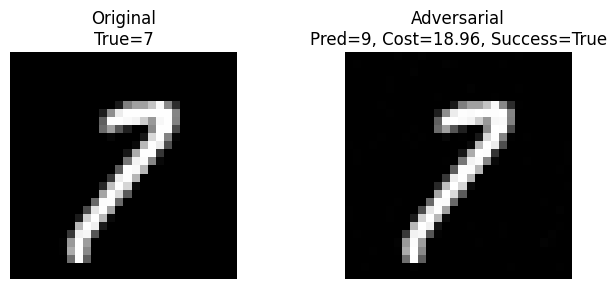

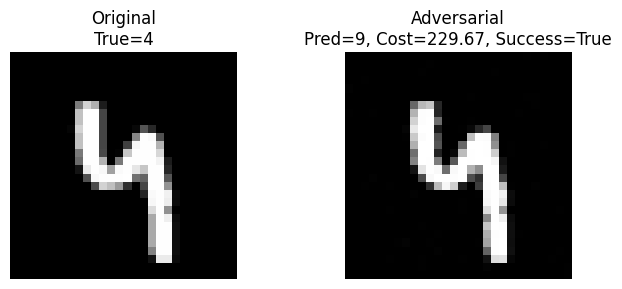

Results for XGBClassifier_mnist saved.

Evaluating model: LGBMClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9505, F1 score: 0.9505
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    8
Success rate:     0.4000
Average cost:     12.9762
Minimum cost:     0.0000


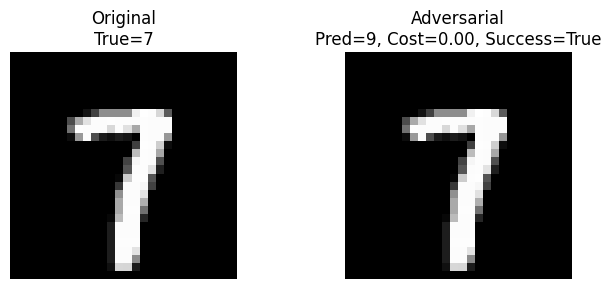

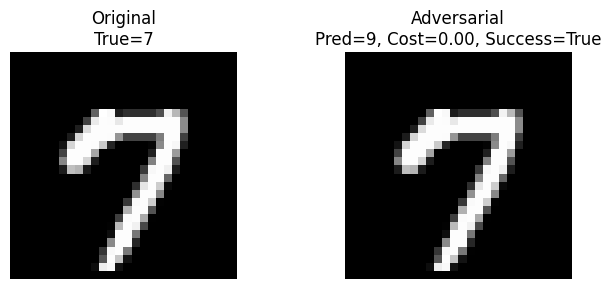

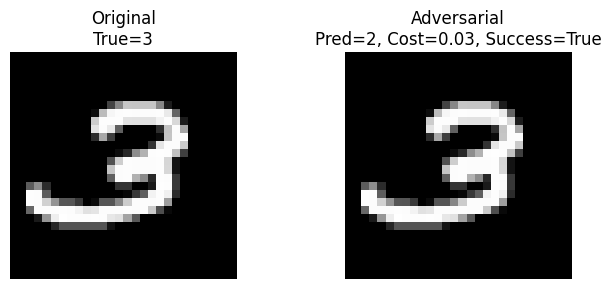

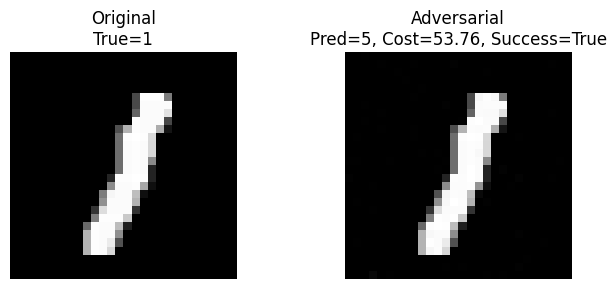

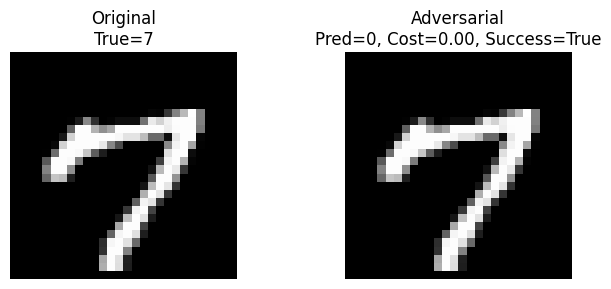

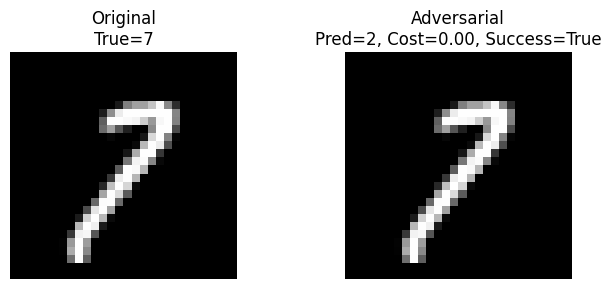

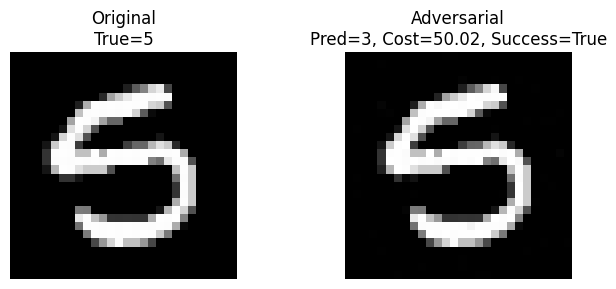

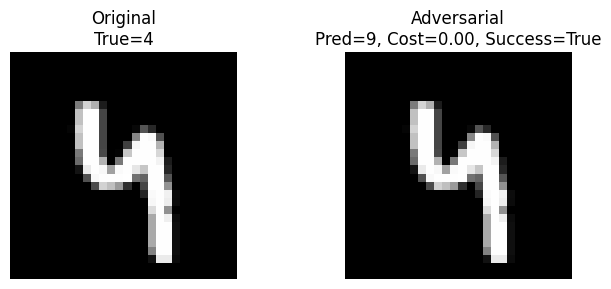

Results for LGBMClassifier_mnist saved.

Evaluating model: HistGradientBoostingClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9545, F1 score: 0.9545
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    6
Success rate:     0.3000
Average cost:     49.2893
Minimum cost:     8.3783


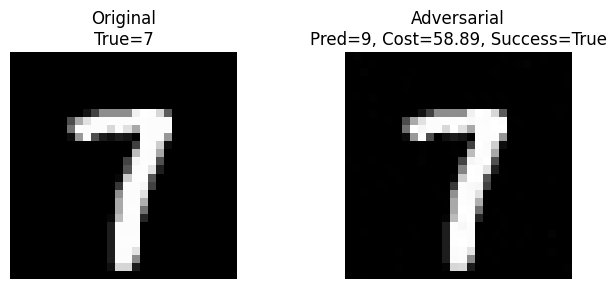

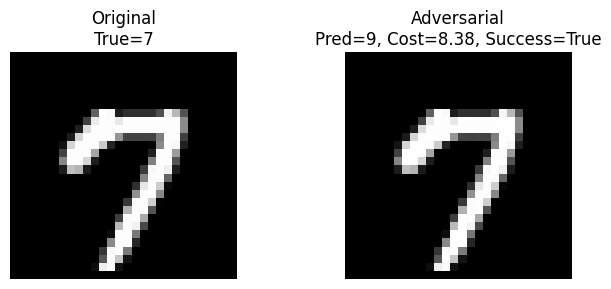

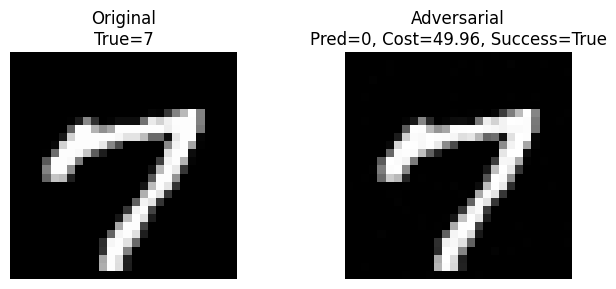

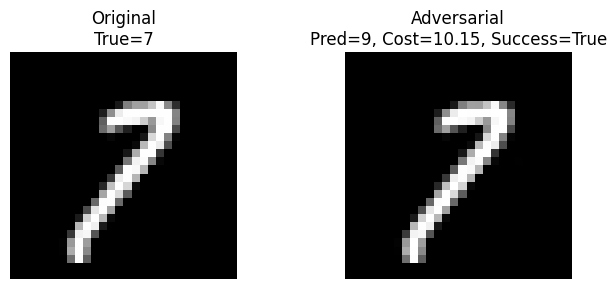

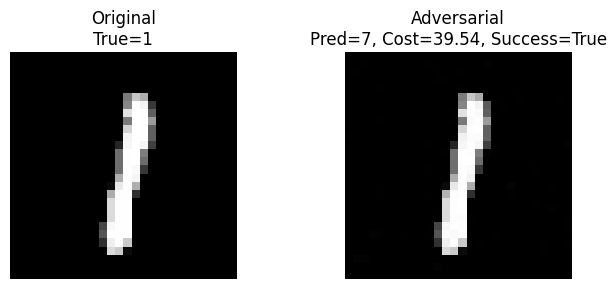

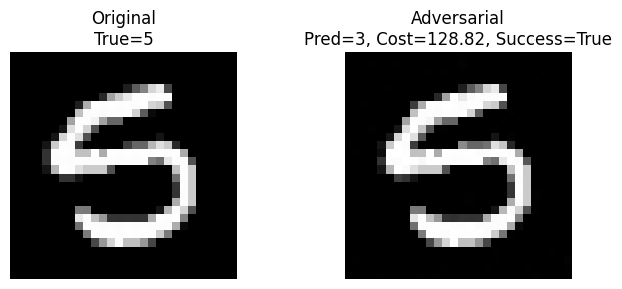

Results for HistGradientBoostingClassifier_mnist saved.

Evaluating model: ExtraTreesClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9525, F1 score: 0.9523
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    1
Success rate:     0.0500
Average cost:     164.5948
Minimum cost:     164.5948


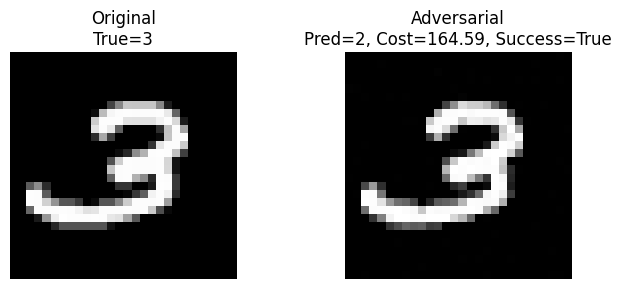

Results for ExtraTreesClassifier_mnist saved.

Evaluating model: RidgeClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.7930, F1 score: 0.7946
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    9
Success rate:     0.4500
Average cost:     115.1299
Minimum cost:     0.0000


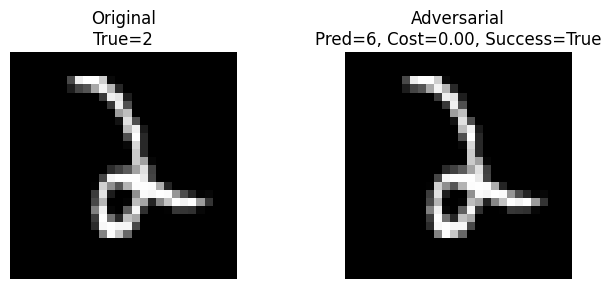

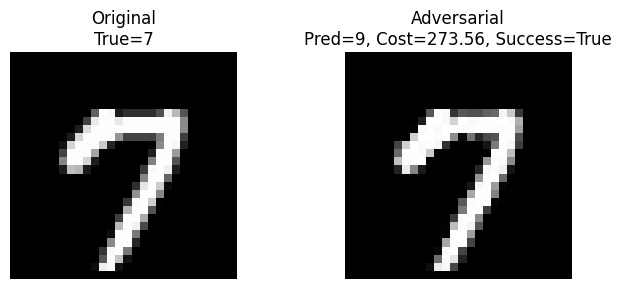

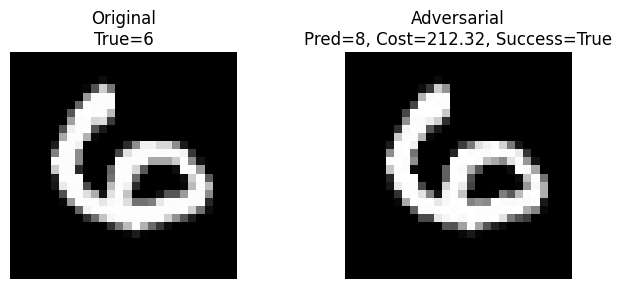

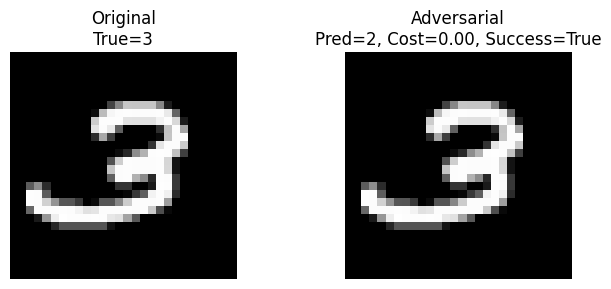

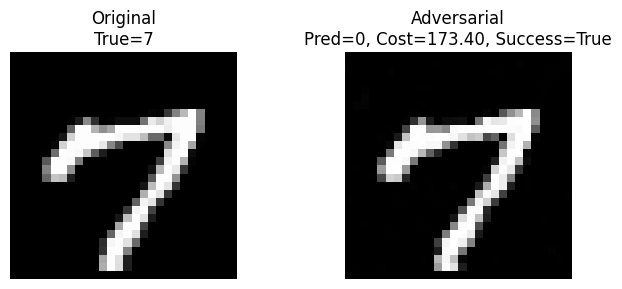

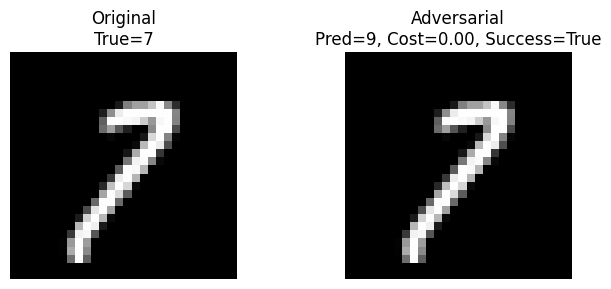

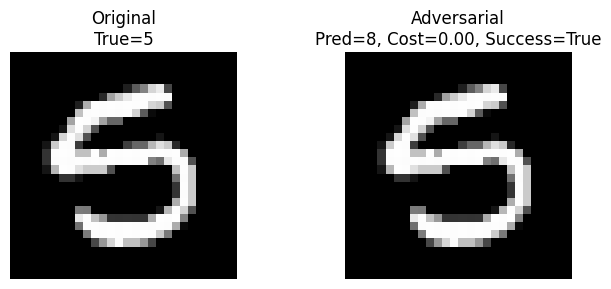

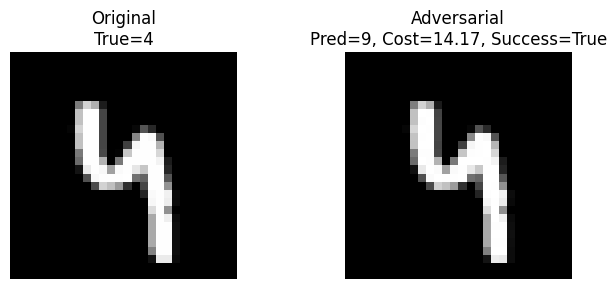

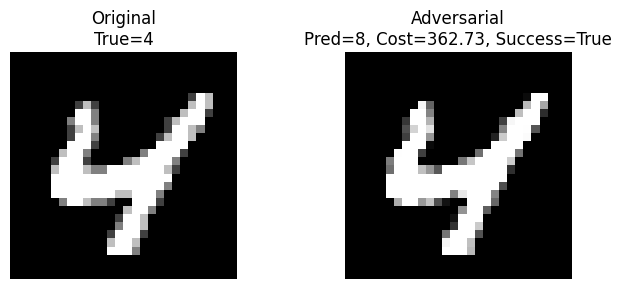

Results for RidgeClassifier_mnist saved.

Evaluating model: SVC_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.1055, F1 score: 0.0201
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    16
Success rate:     0.8000
Average cost:     0.0000
Minimum cost:     0.0000


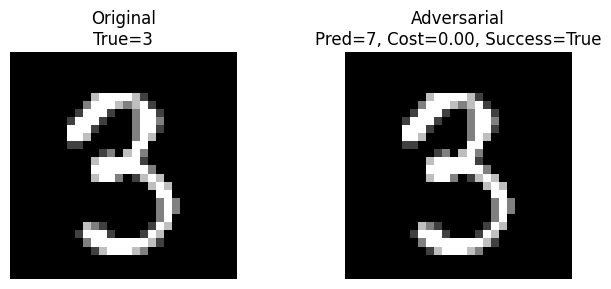

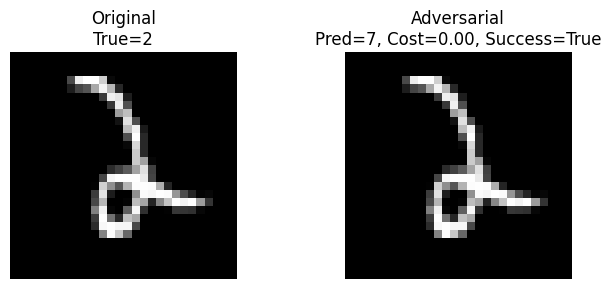

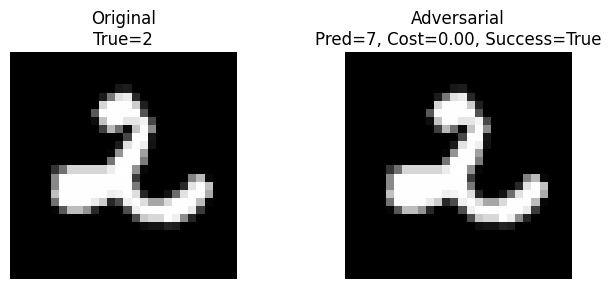

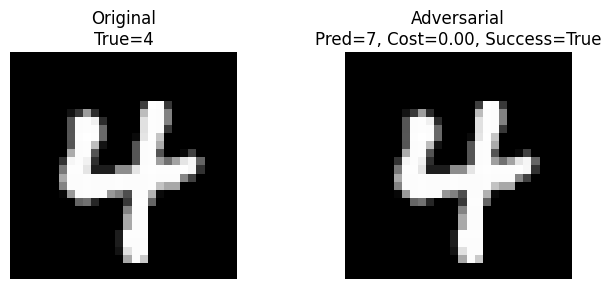

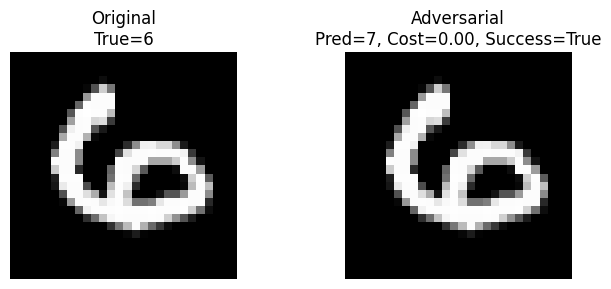

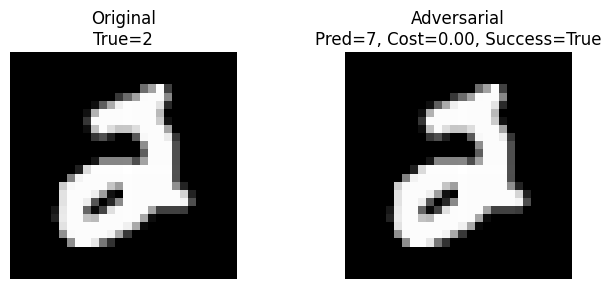

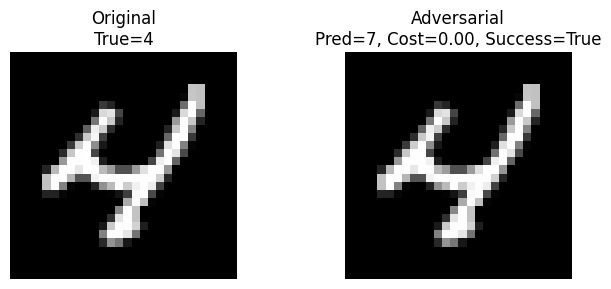

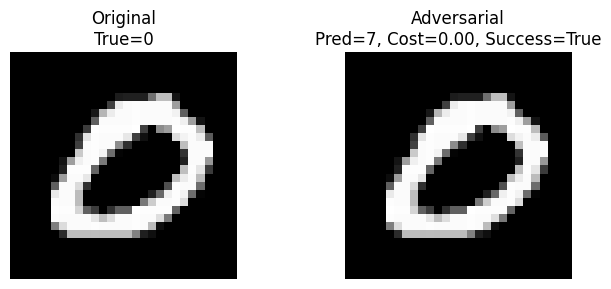

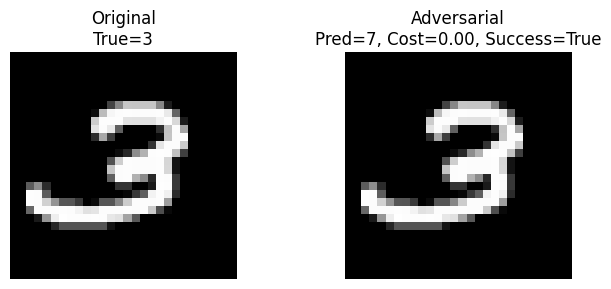

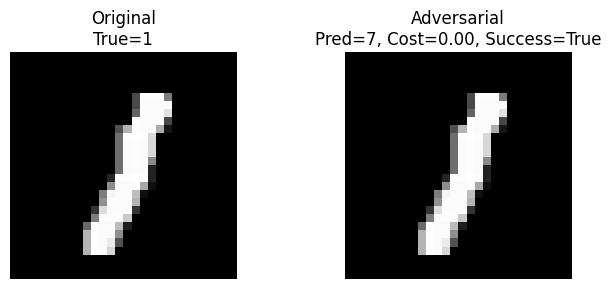

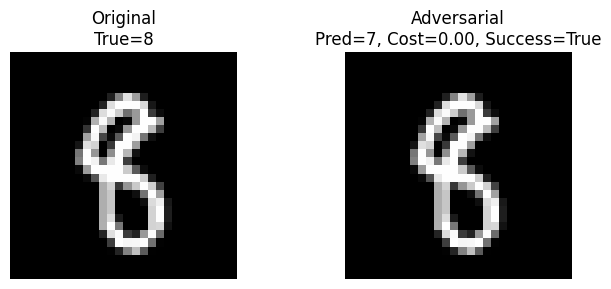

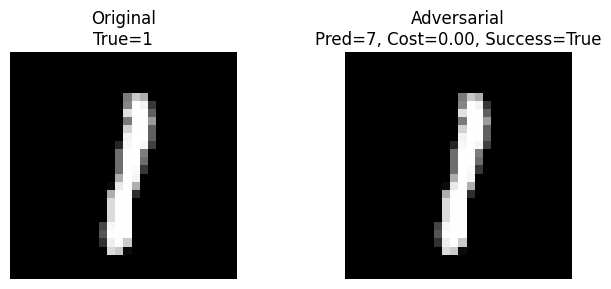

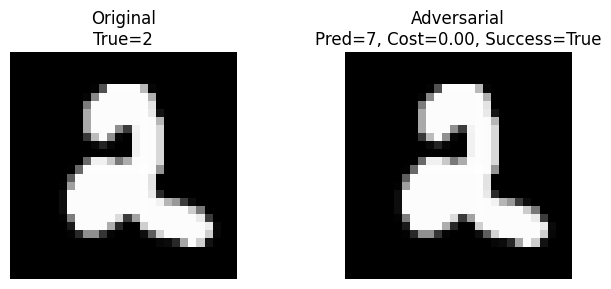

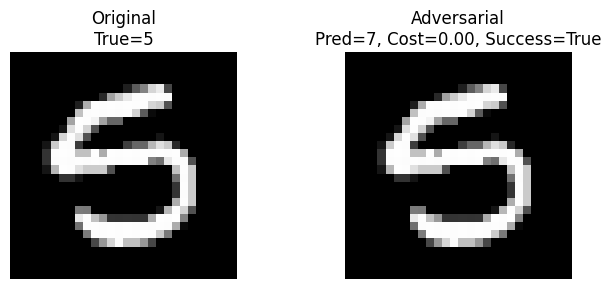

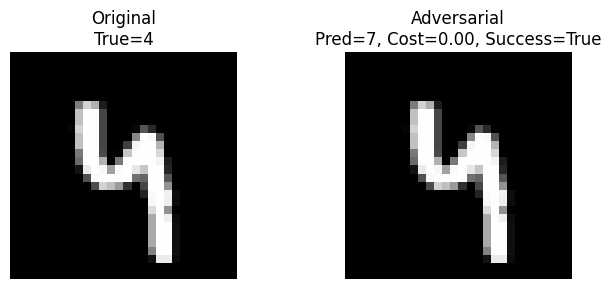

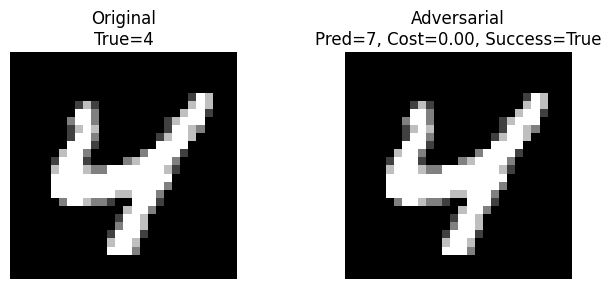

Results for SVC_mnist saved.

Evaluating model: PassiveAggressiveClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.6550, F1 score: 0.6819
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    14
Success rate:     0.7000
Average cost:     96.1509
Minimum cost:     0.0000


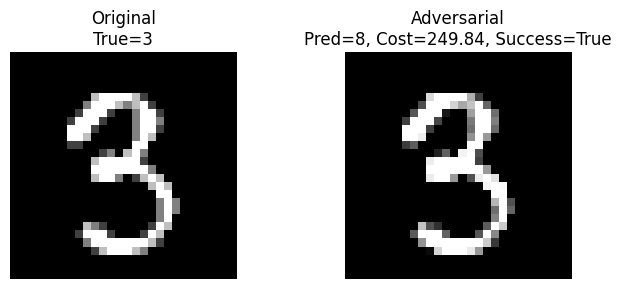

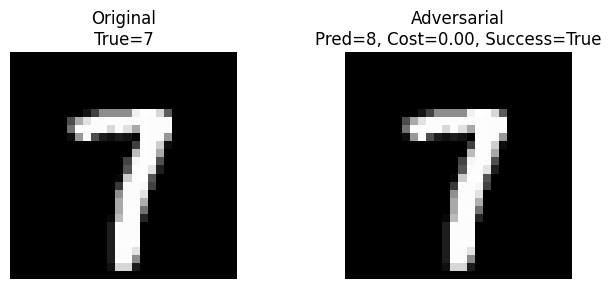

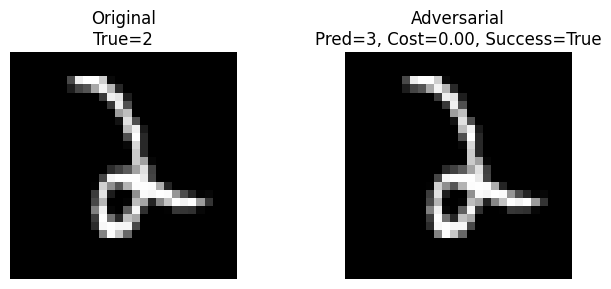

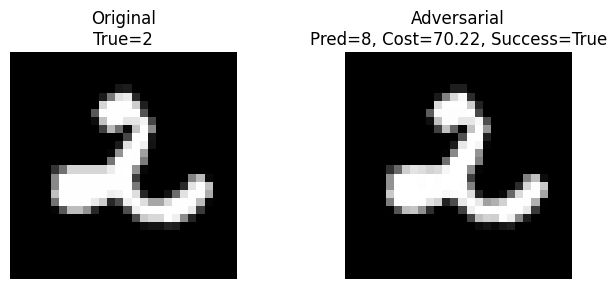

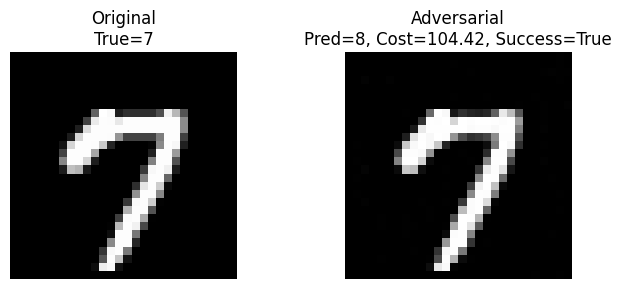

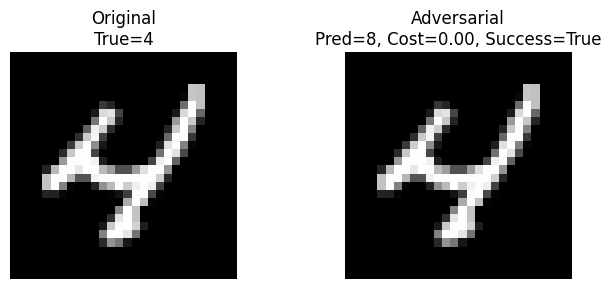

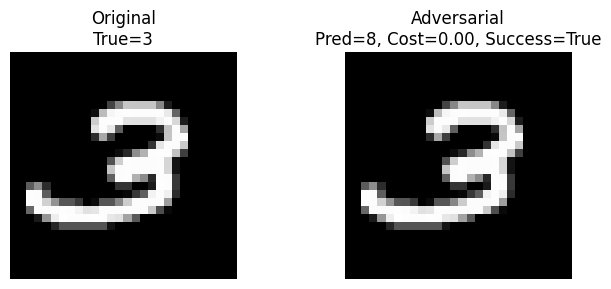

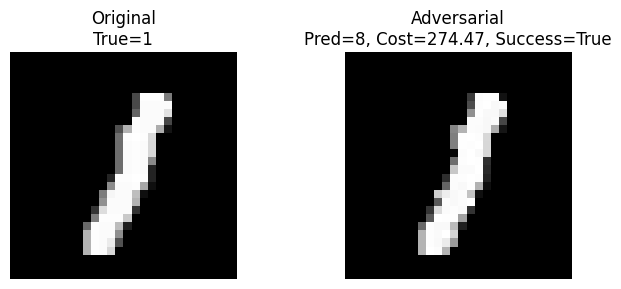

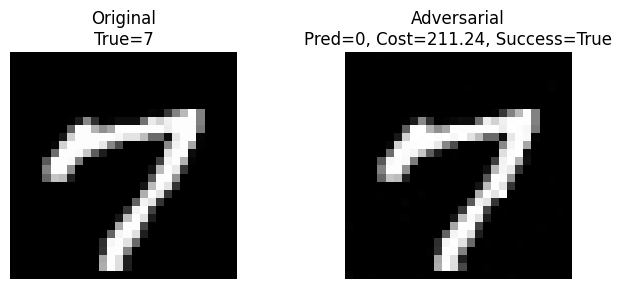

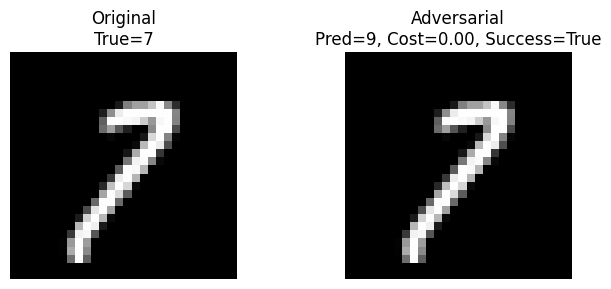

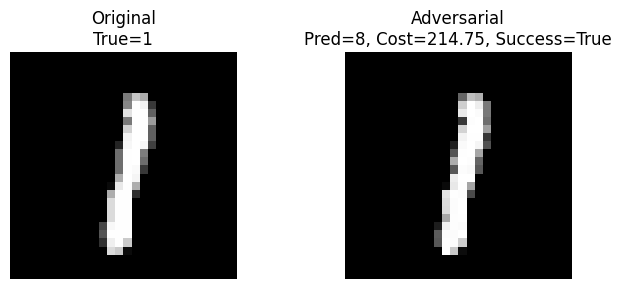

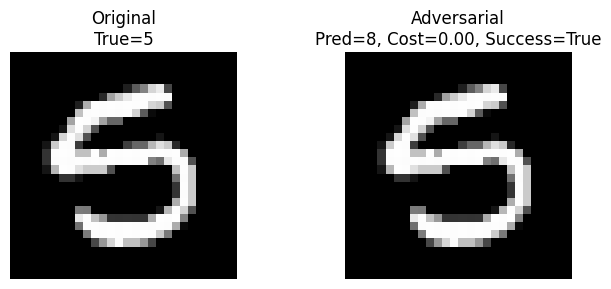

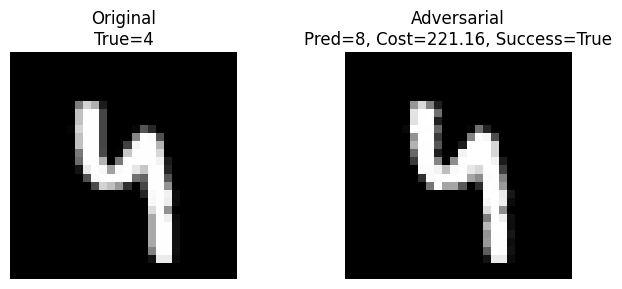

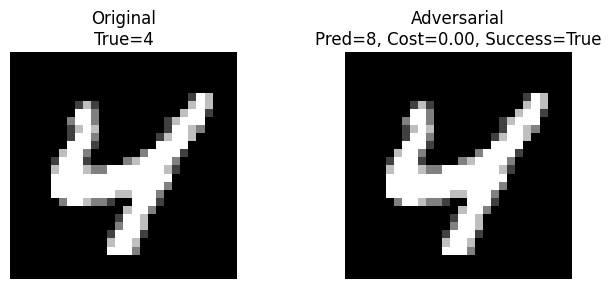

Results for PassiveAggressiveClassifier_mnist saved.

Evaluating model: LinearDiscriminantAnalysis_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.8205, F1 score: 0.8142
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    6
Success rate:     0.3000
Average cost:     83.5937
Minimum cost:     0.0000


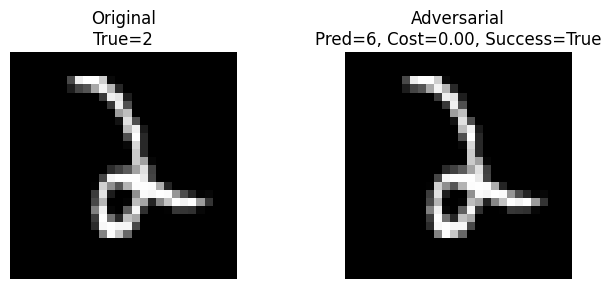

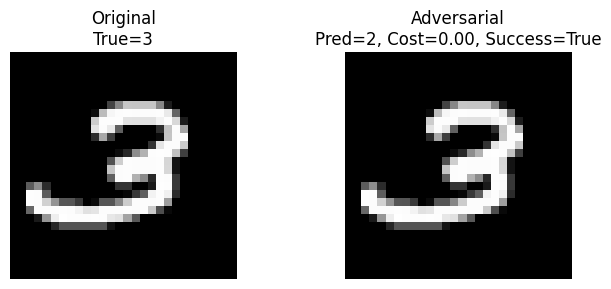

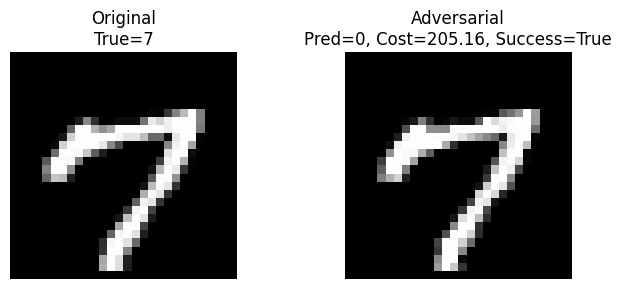

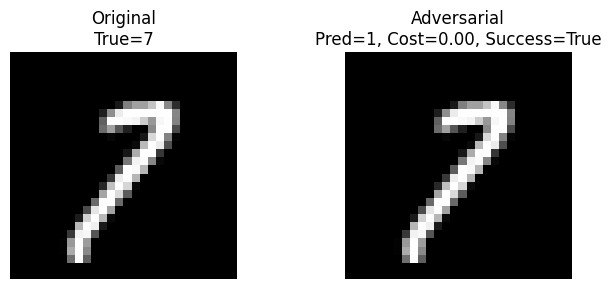

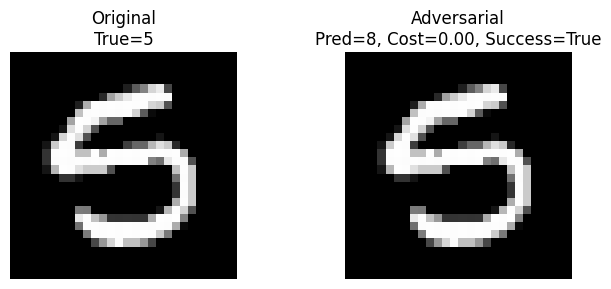

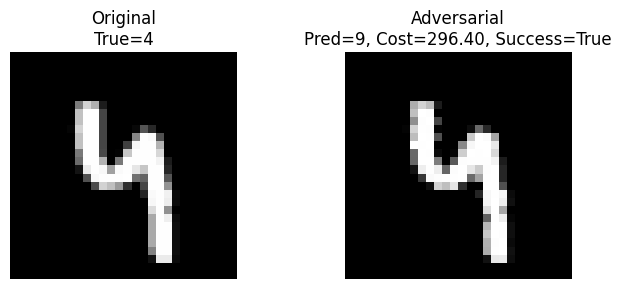

Results for LinearDiscriminantAnalysis_mnist saved.


In [16]:
# Define a function to apply `custom_cost_protocol` to all MNIST models
def evaluate_mnist_models(X, y, models, constraints, image_shape=(28, 28, 1), 
                           random_state=42, save_path="mnist_results", 
                           neighborhood_default_max_iter=1000, 
                           heuristic_max_iter=100, heuristic_patience=100):
    """
    Apply `custom_cost_protocol` to all MNIST models and save results for each model.
    
    Parameters:
        X (pd.DataFrame): Feature set for MNIST.
        y (pd.Series): Target labels for MNIST.
        models (dict): Dictionary containing model name as key and model object as value.
        constraints (dict): Constraints dictionary for the attacks.
        image_shape (tuple): Shape of the images (default is (28, 28, 1)).
        random_state (int): Random seed for reproducibility.
        save_path (str): Directory where results will be saved.
        neighborhood_default_max_iter (int): Max iterations for neighborhood generation.
        heuristic_max_iter (int): Max iterations for attack heuristic.
        heuristic_patience (int): Patience parameter for attack heuristic.
    
    Returns:
        results_dict (dict): Dictionary containing results for all models.
    """
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    results_dict = {}

    for model_name, model in models.items():
        if "mnist" not in model_name:  # Only process MNIST models
            continue

        print(f"\nEvaluating model: {model_name}")
        try:
            results = custom_cost_protocol(
                X=X,
                y=y,
                targeted=False,
                images=True,
                cost_profit_func=None,  # Use L2 default for images
                estimator=model,
                adv_samples=20,
                constraints=constraints,
                image_shape=image_shape,
                random_state=random_state,
                neighborhood_default_max_iter=neighborhood_default_max_iter,
                heuristic_max_iter=heuristic_max_iter,
                heuristic_patience=heuristic_patience,
                use_joblib=True, # for parallel processing
                dataset_name="MNIST",
            )
            # Save results to dictionary
            results_dict[model_name] = results

            # Save results to a CSV file for later analysis
            results_df = pd.DataFrame(results["results"], columns=["Best Candidate", "Cost", "Success"])
            results_df.to_csv(os.path.join(save_path, f"{model_name}_results_{heuristic_max_iter}.csv"), index=False)

            print(f"Results for {model_name} saved.")
        
        except Exception as e:
            print(f"Error evaluating model {model_name}: {e}")

    return results_dict


# Example usage
mnist_results = evaluate_mnist_models( # 81m 51.7s
    X=X_mnist,
    y=y_mnist,
    models={key: val for key, val in models.items() if "mnist" in key},
    constraints=constraints_mnist,
    image_shape=(28, 28, 1),
    random_state=SEED,
    save_path="mnist_results",
    neighborhood_default_max_iter=1000,
    heuristic_max_iter=1000,
    heuristic_patience=1000,
)

In [17]:
# Re-evaluate SVC that didn't behave as expected

m = {key: val for key, val in models.items() if ("mnist" in key and "SVC" in key)}
print(m)

{'SVC_mnist': SVC(random_state=5)}


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.3, random_state=SEED)

svc = m["SVC_mnist"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Dataset: mnist, Model: SVC, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

Dataset: mnist, Model: SVC, Accuracy: 0.9333, F1-Score: 0.9334


In [20]:
del X_train, X_test, y_train, y_test
gc.collect()

8907

We forgot to apply standard scaler to the data before attacking. We will do this now.

In [22]:
X_mnist_scaled = scaler.transform(X_mnist)
X_mnist_scaled = pd.DataFrame(X_mnist_scaled, columns=X_mnist.columns)
X_mnist_scaled.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,...,pixel535,pixel536,pixel537,pixel538,pixel539,pixel540,pixel541,pixel542,pixel543,pixel544,pixel545,pixel546,pixel547,pixel548,pixel549,pixel550,pixel551,pixel552,pixel553,pixel554,pixel555,pixel556,pixel557,pixel558,pixel559,pixel560,pixel561,pixel562,pixel563,pixel564,pixel565,pixel566,pixel567,pixel568,pixel569,pixel570,pixel571,pixel572,pixel573,pixel574,pixel575,pixel576,pixel577,pixel578,pixel579,pixel580,pixel581,pixel582,pixel583,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740


Evaluating model: RidgeClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.8420, F1 score: 0.8407
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    20
Success rate:     1.0000
Average cost:     13.2114
Minimum cost:     0.0000


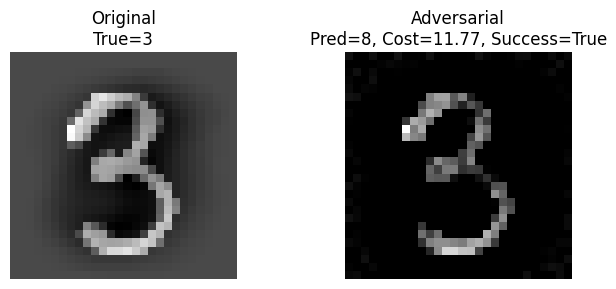

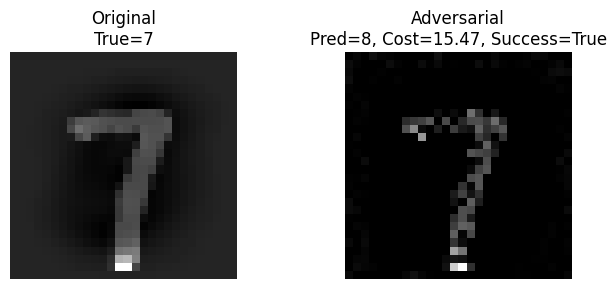

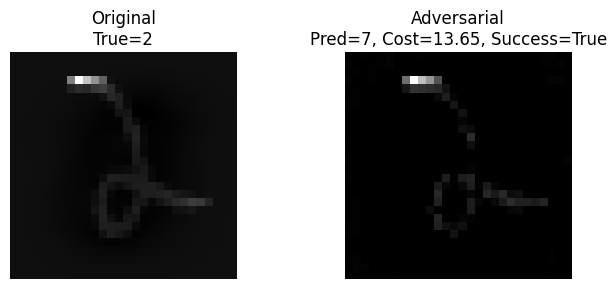

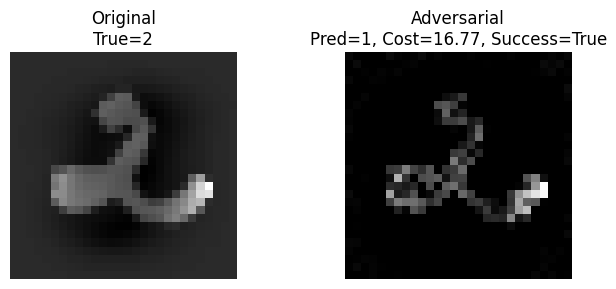

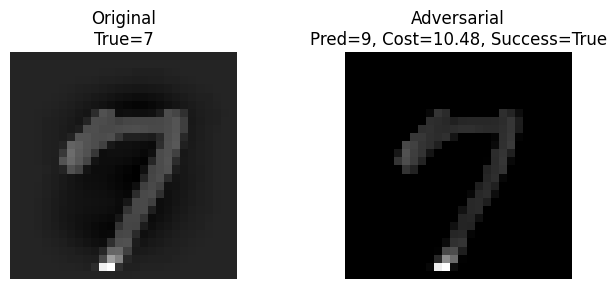

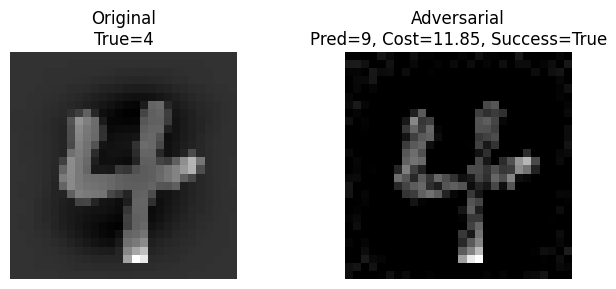

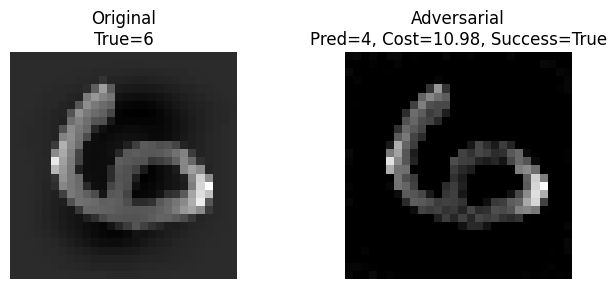

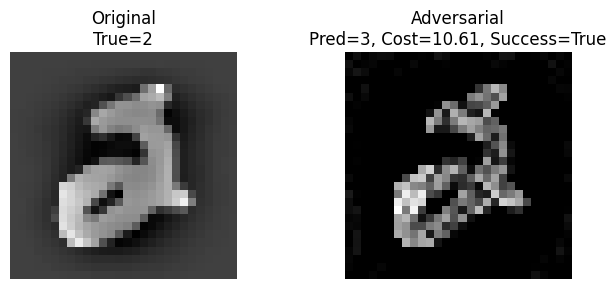

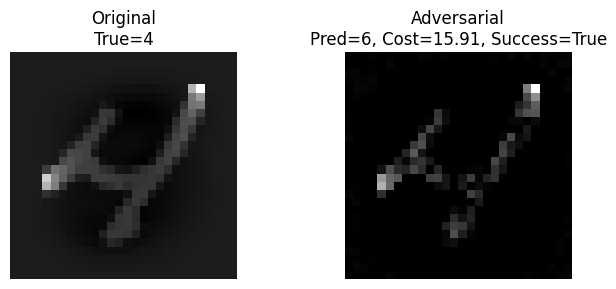

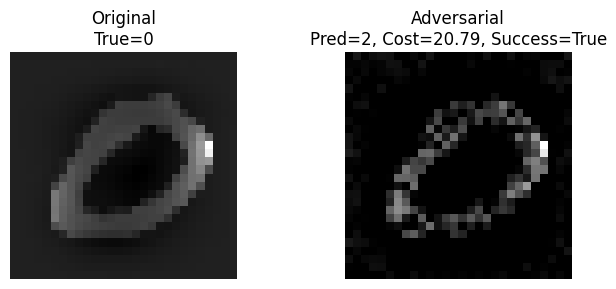

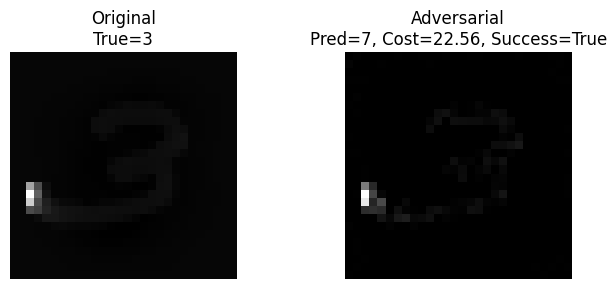

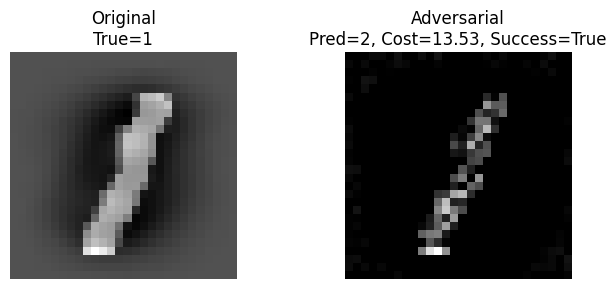

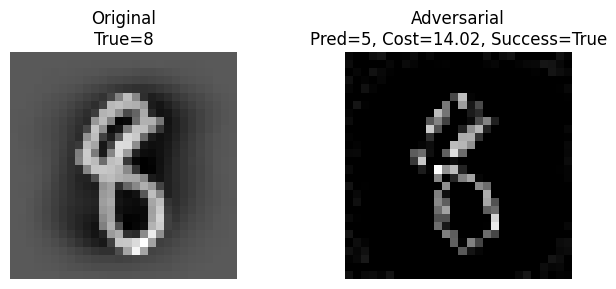

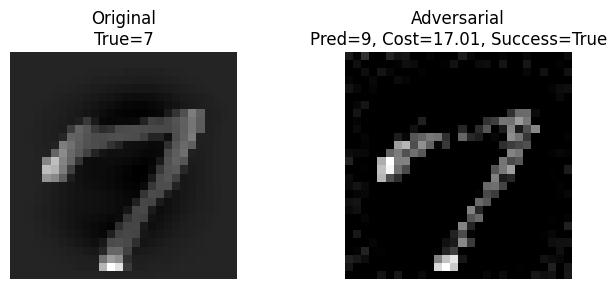

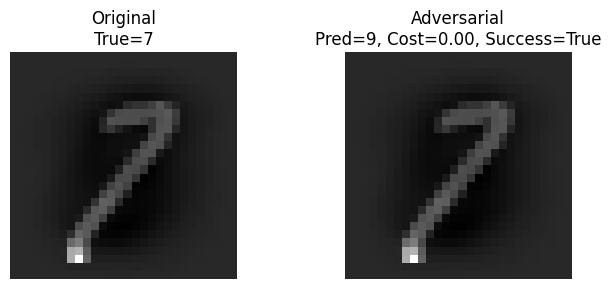

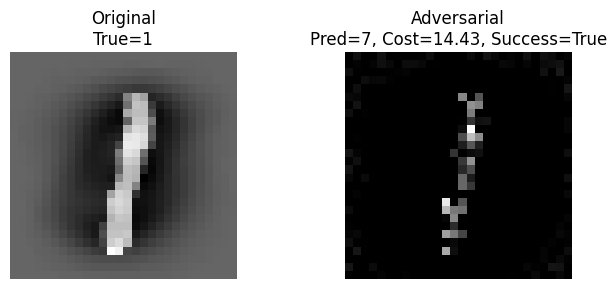

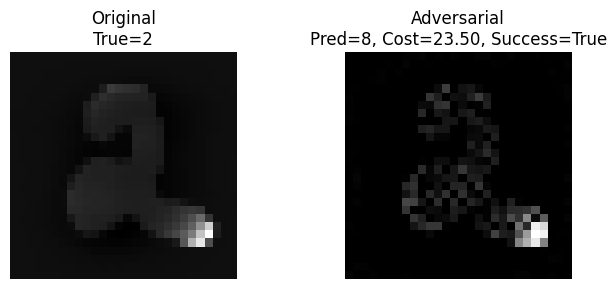

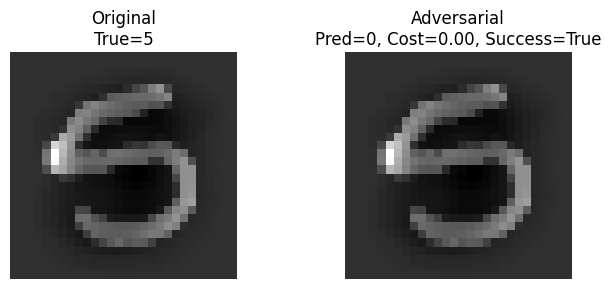

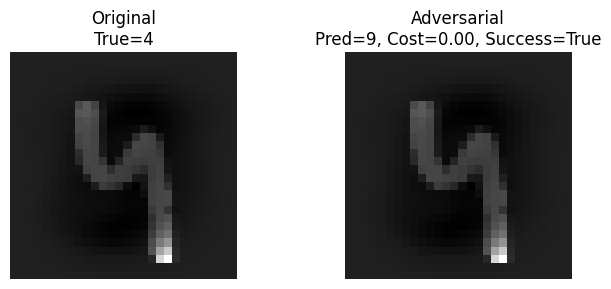

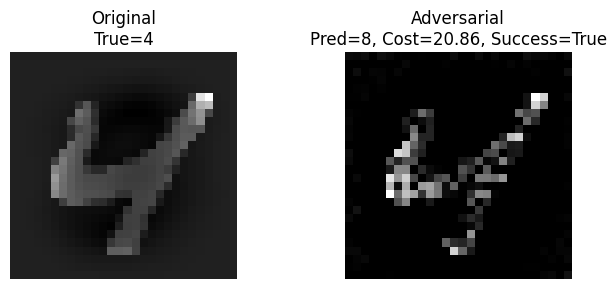

Results for RidgeClassifier_mnist saved.

Evaluating model: SVC_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9340, F1 score: 0.9341
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    20
Success rate:     1.0000
Average cost:     19.6318
Minimum cost:     10.3787


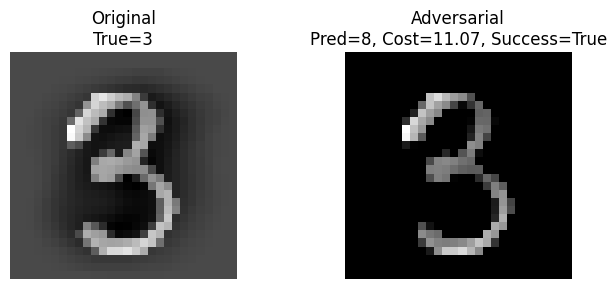

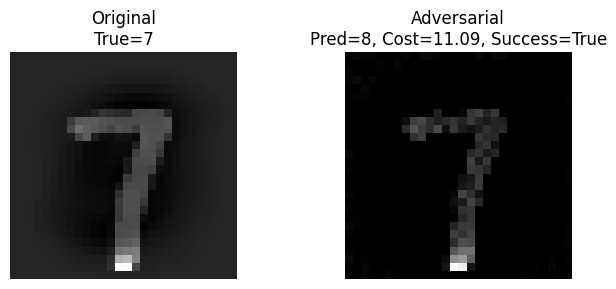

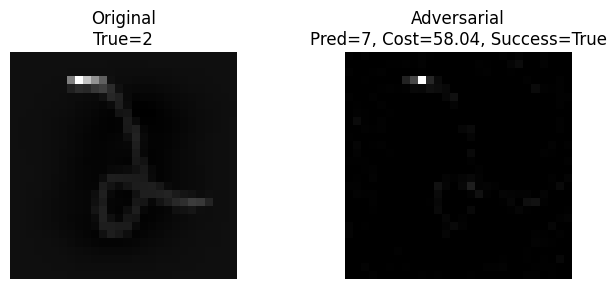

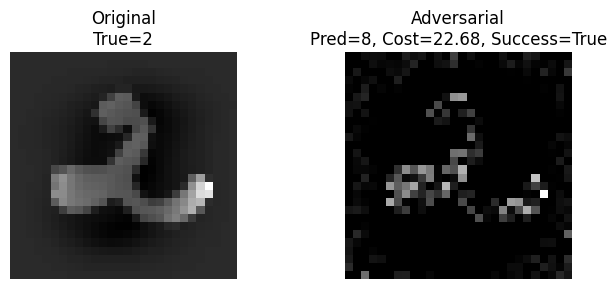

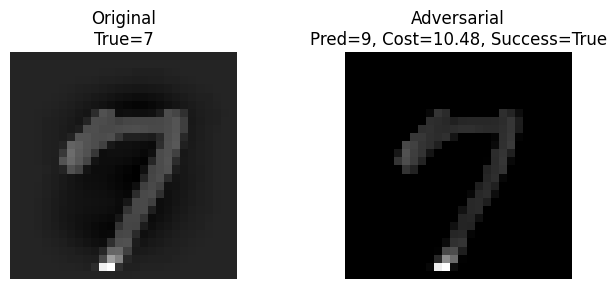

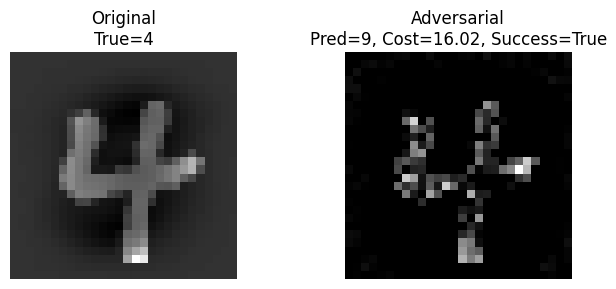

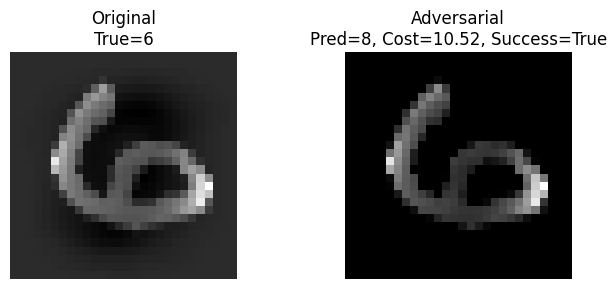

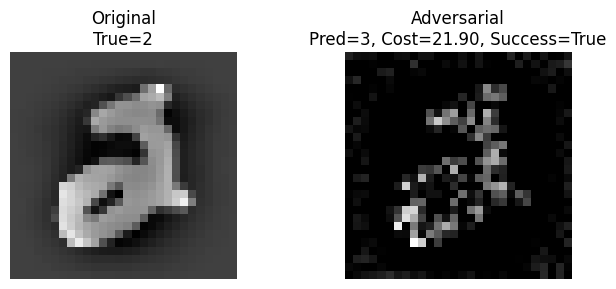

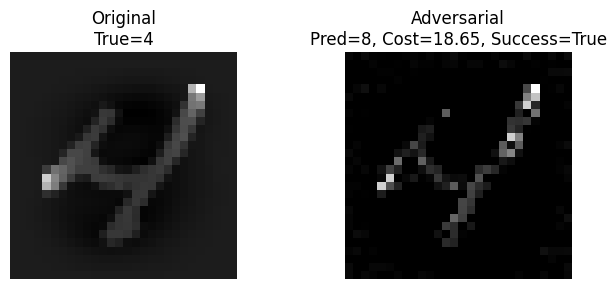

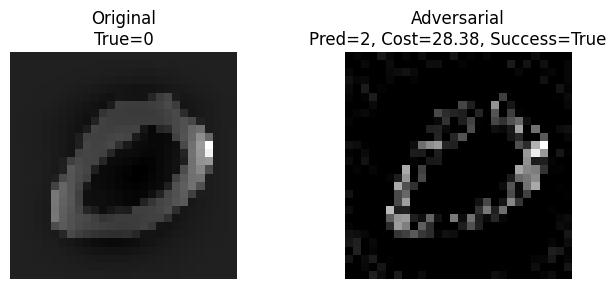

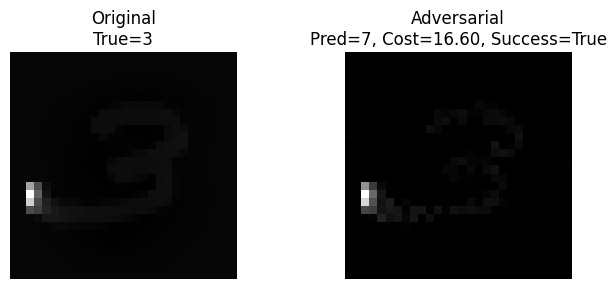

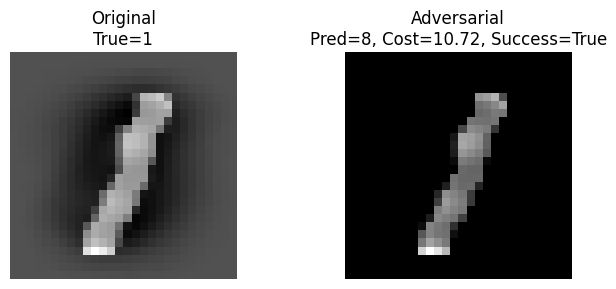

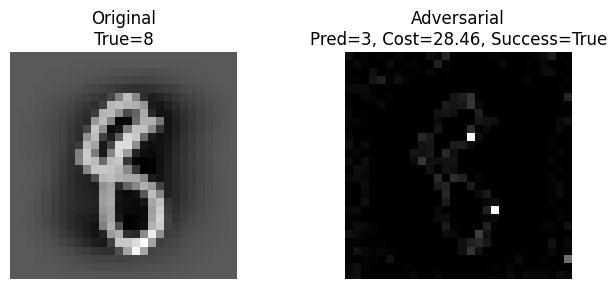

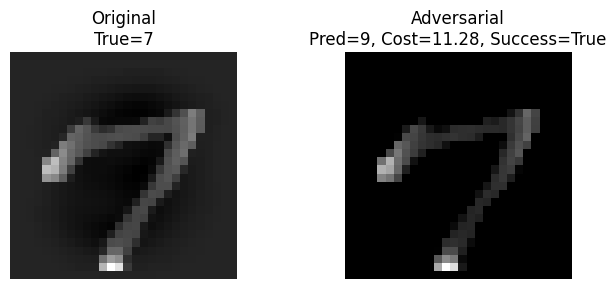

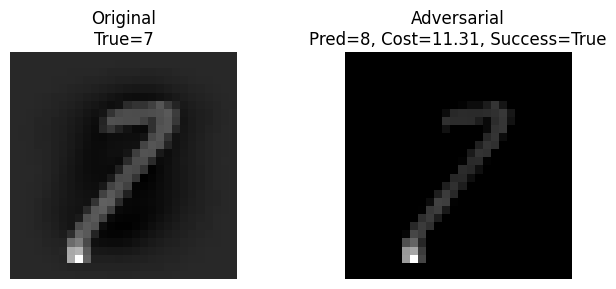

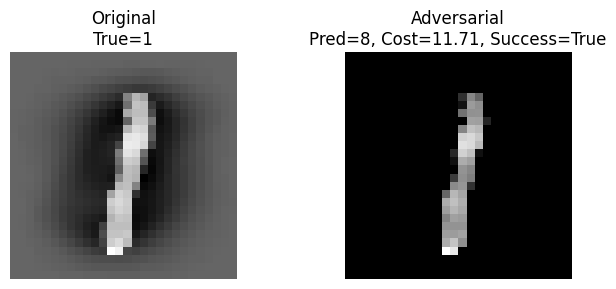

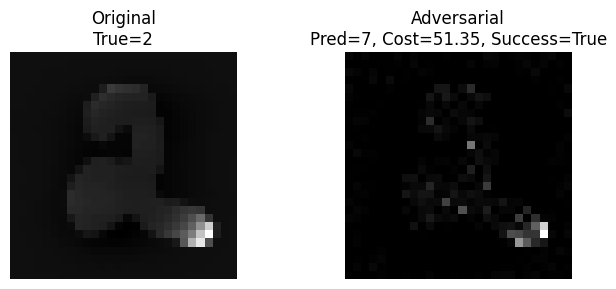

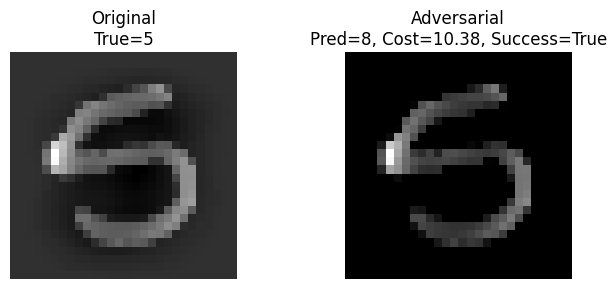

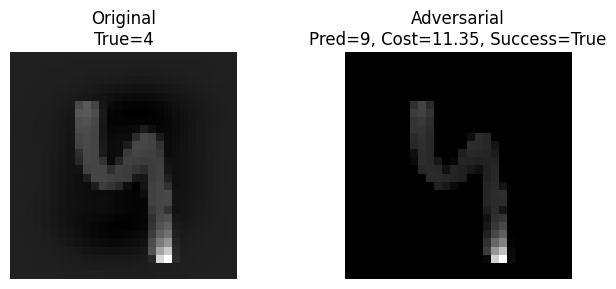

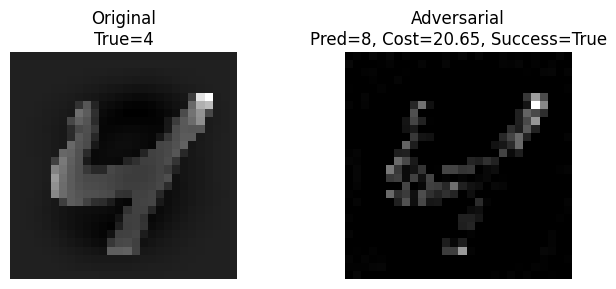

Results for SVC_mnist saved.

Evaluating model: PassiveAggressiveClassifier_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.8680, F1 score: 0.8678
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    20
Success rate:     1.0000
Average cost:     13.1913
Minimum cost:     0.0000


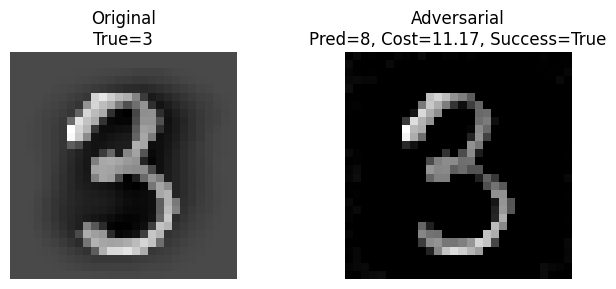

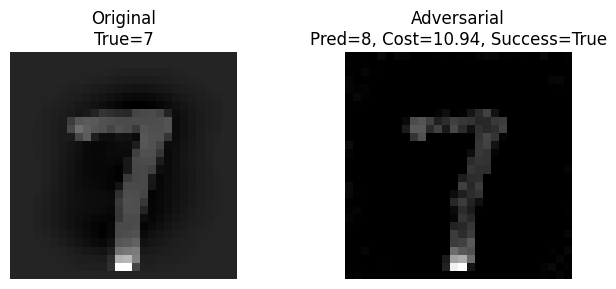

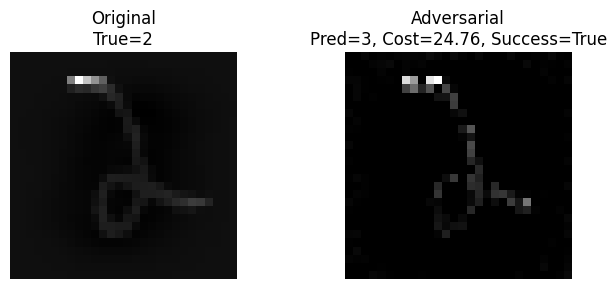

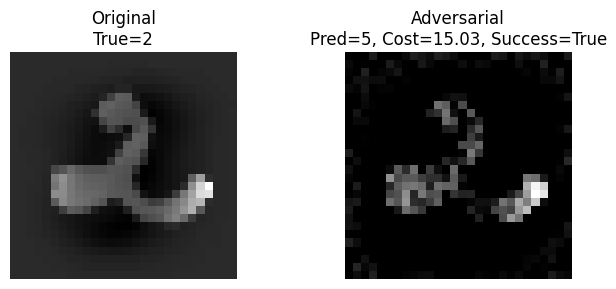

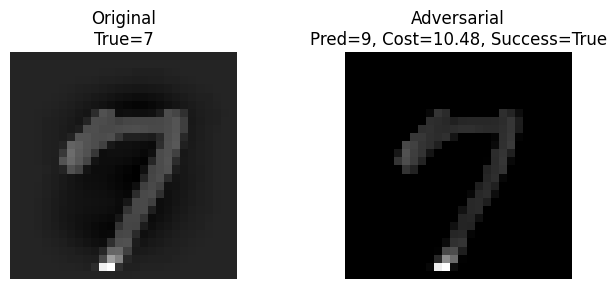

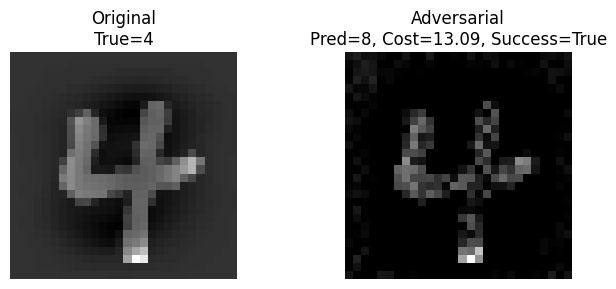

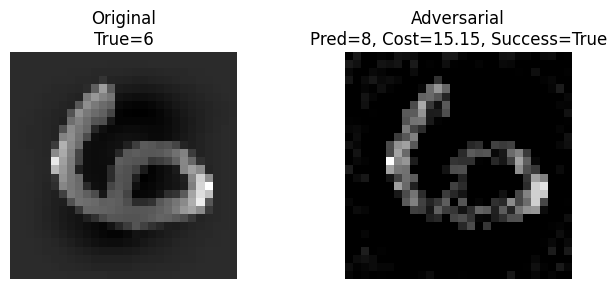

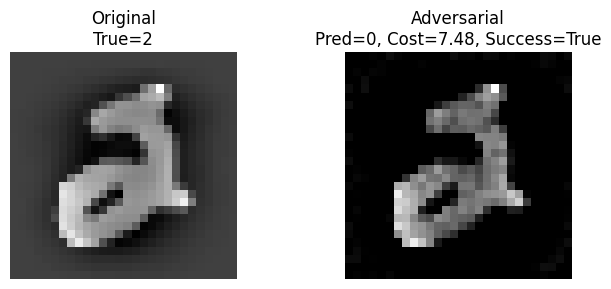

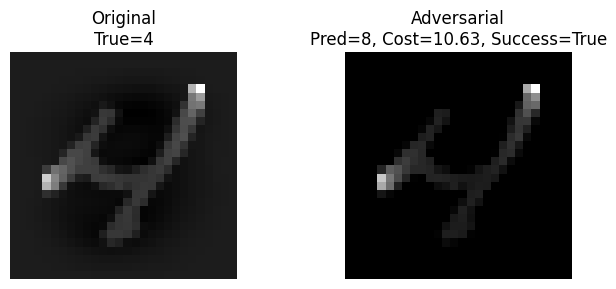

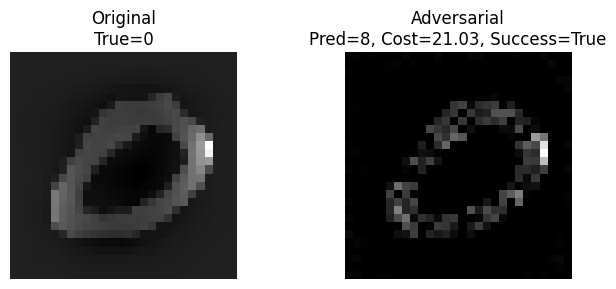

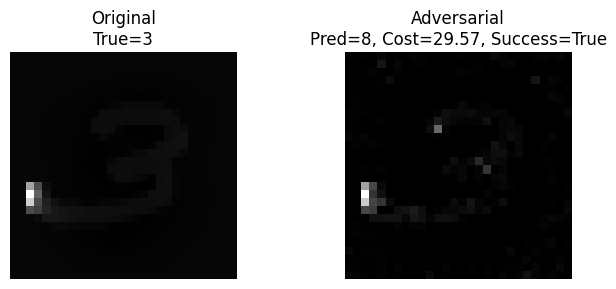

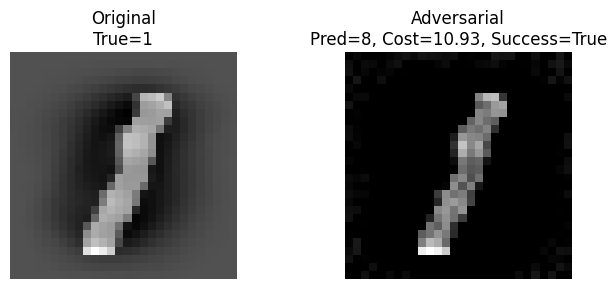

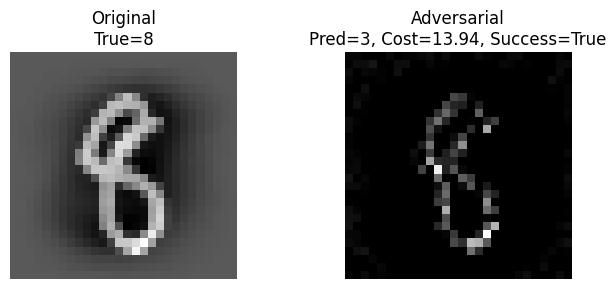

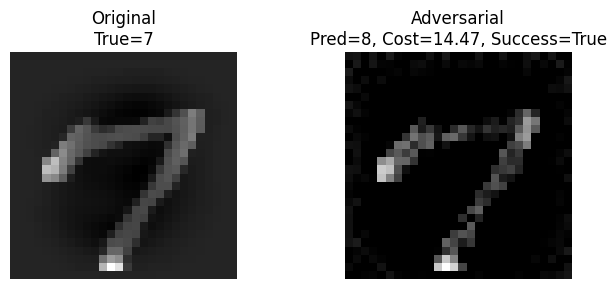

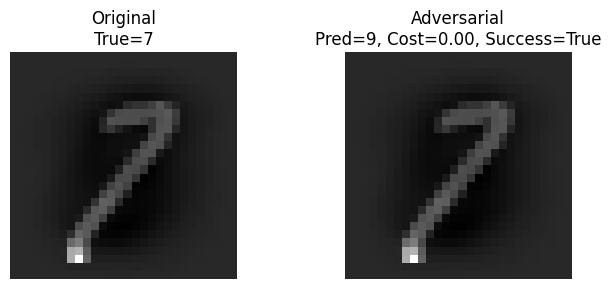

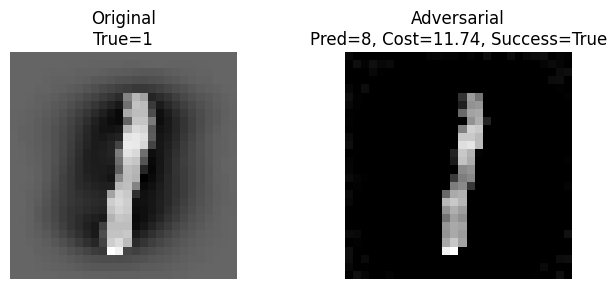

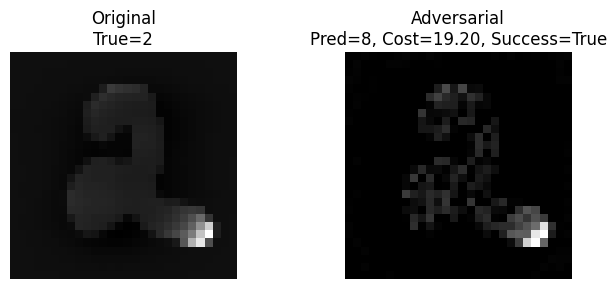

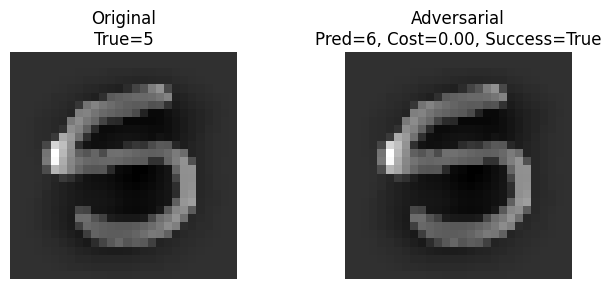

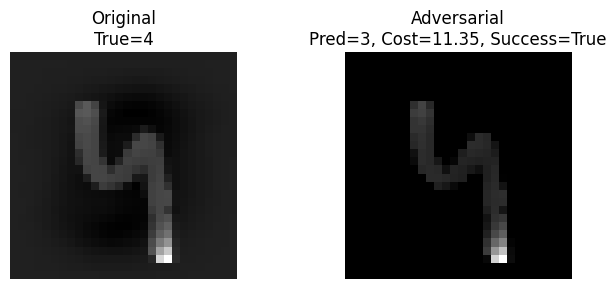

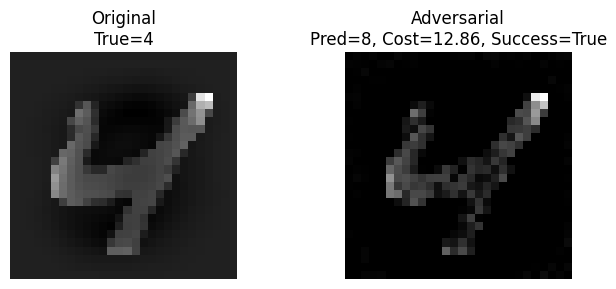

Results for PassiveAggressiveClassifier_mnist saved.

Evaluating model: LinearDiscriminantAnalysis_mnist
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.8600, F1 score: 0.8598
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using L2 norm for images.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 20
Success count:    20
Success rate:     1.0000
Average cost:     12.7460
Minimum cost:     0.0000


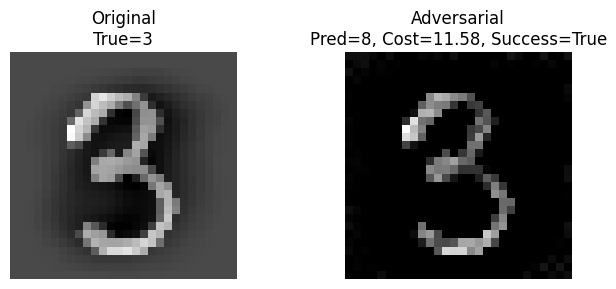

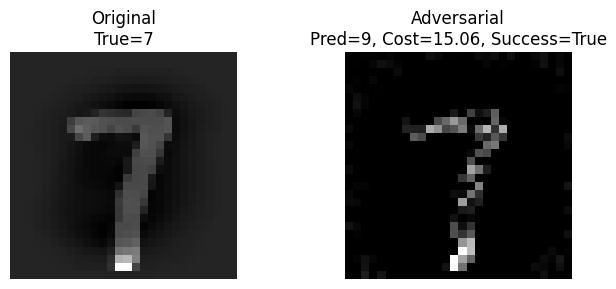

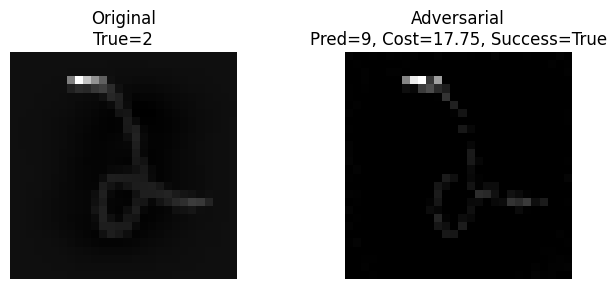

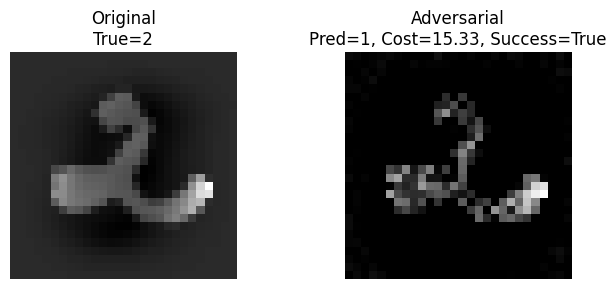

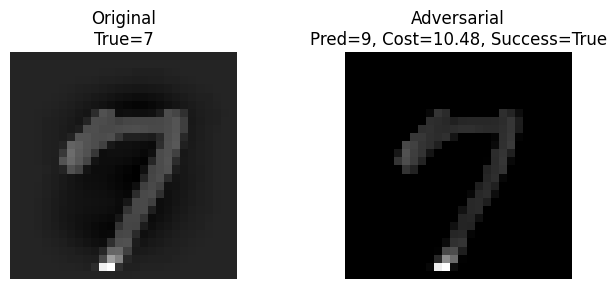

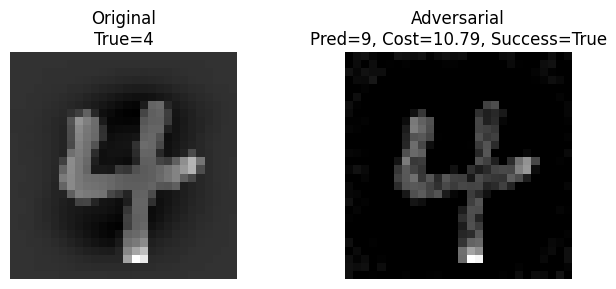

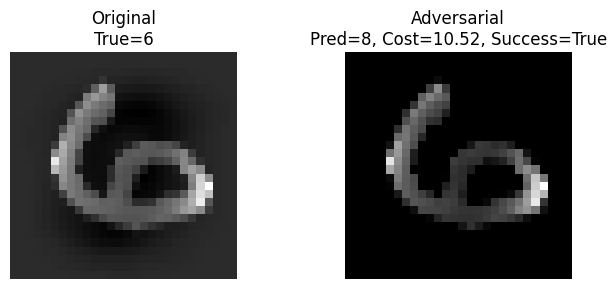

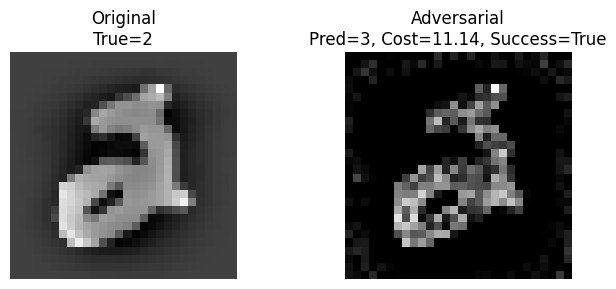

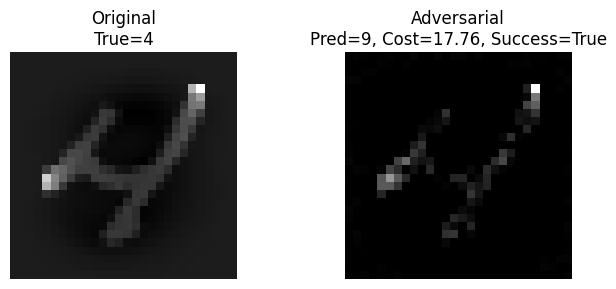

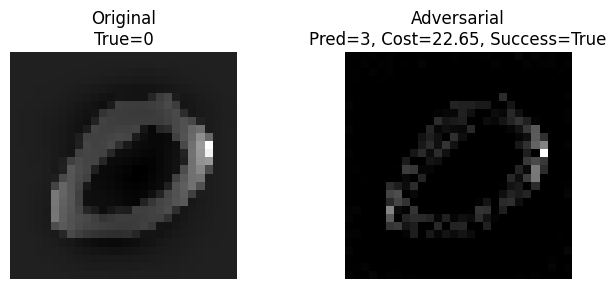

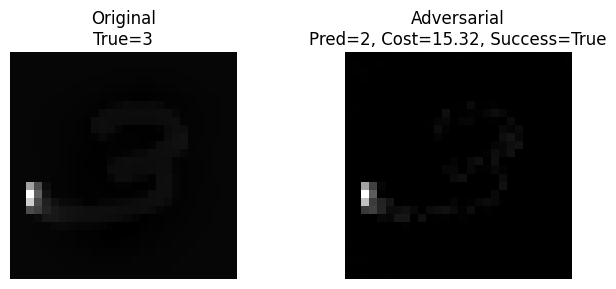

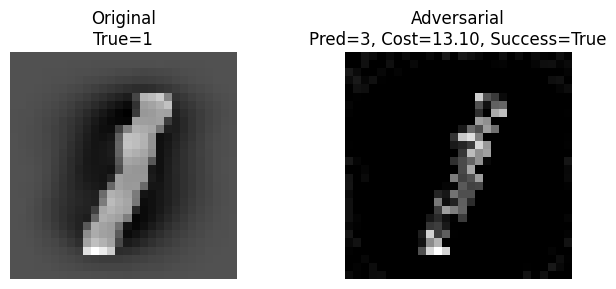

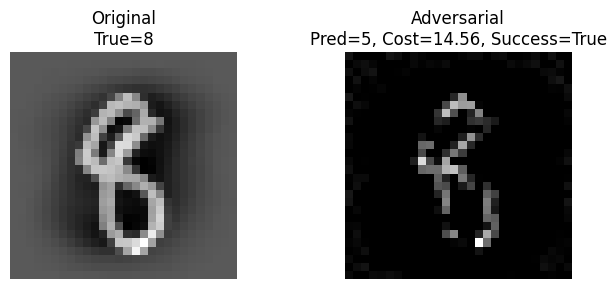

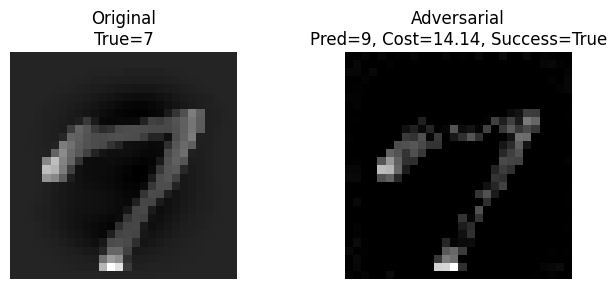

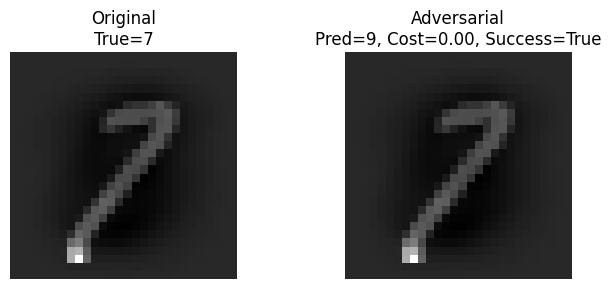

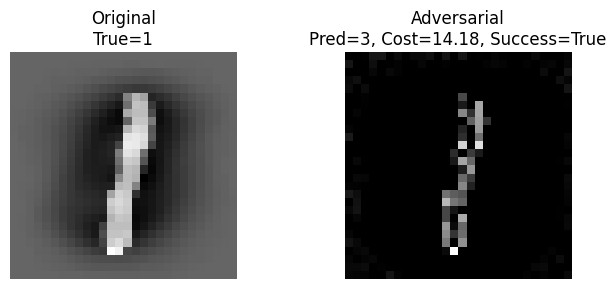

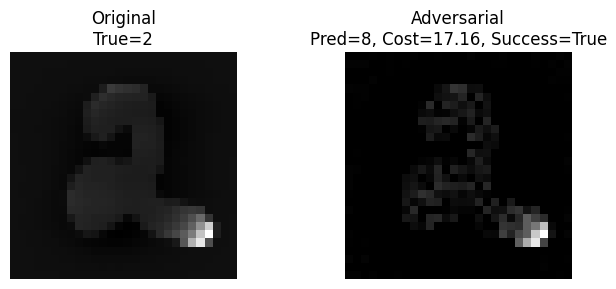

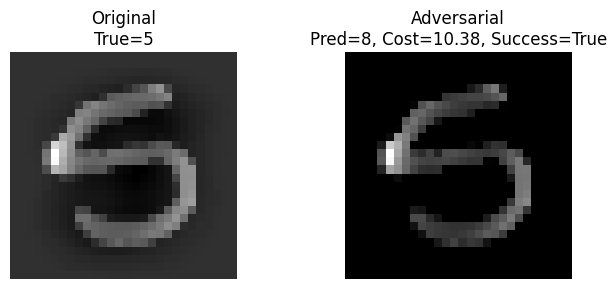

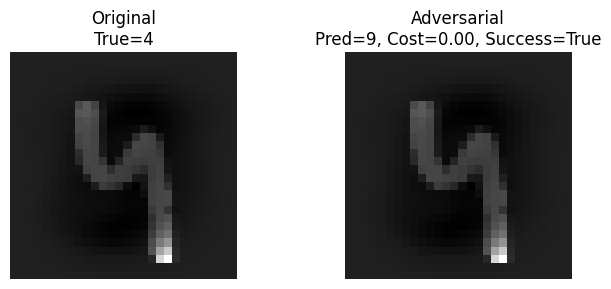

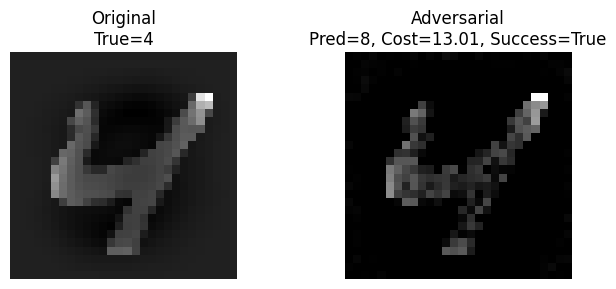

Results for LinearDiscriminantAnalysis_mnist saved.


In [23]:
mnist_results = evaluate_mnist_models(
    X=X_mnist_scaled,
    y=y_mnist,
    models={key: val for key, val in models.items() if ("mnist" in key and ("SVC" in key or "Discriminant" in key or "Passive" in key or "Ridge" in key))},
    constraints=constraints_mnist,
    image_shape=(28, 28, 1),
    random_state=SEED,
    save_path="mnist",
    neighborhood_default_max_iter=1000,
    heuristic_max_iter=1000,
    heuristic_patience=1000,
)

In [9]:
def evaluate_ccf_models(X, y, models, constraints, random_state=42, save_path="ccf_results", 
                           neighborhood_default_max_iter=1000, 
                           heuristic_max_iter=100, heuristic_patience=100,
                           cost_profit_func=None, joblib=True):

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    results_dict = {}

    for model_name, model in models.items():
        if "cff" not in model_name:  # Only process ccf models
            continue

        print(f"Evaluating model: {model_name}")
        try:
            results = custom_cost_protocol(
                X=X,
                y=y,
                targeted=True,
                target_class=0, # fraud --> not fraud
                images=False,
                adv_samples=100,
                cost_profit_func=cost_profit_func,
                estimator=model,
                constraints=constraints,
                random_state=random_state,
                neighborhood_default_max_iter=neighborhood_default_max_iter,
                heuristic_max_iter=heuristic_max_iter,
                heuristic_patience=heuristic_patience,
                use_joblib=joblib # for parallel processing
            )
            # Save results to dictionary
            results_dict[model_name] = results

            # Save results to a CSV file for later analysis
            results_df = pd.DataFrame(results["results"], columns=["Best Candidate", "Cost", "Success"])
            results_df.to_csv(os.path.join(save_path, f"{model_name}_results.csv"), index=False)

            print(f"Results for {model_name} saved.")
        
        except Exception as e:
            raise(e)
            print(f"Error evaluating model {model_name}: {e}")

    return results_dict

In [ ]:
# Unscaled datasets
ccf_results = evaluate_ccf_models( # 40m 43.6s
    X=X_credit,
    y=y_credit,
    models={key: val for key, val in models.items() if "cff" in key and ("XGB" in key or "LGBM" in key or "Hist" in key or "Extra" in key)},
    constraints=constraints_ccf,
    random_state=SEED,
    save_path="ccf_results",
    neighborhood_default_max_iter=10000,
    heuristic_max_iter=1000,
    heuristic_patience=1000,
    cost_profit_func=custom_cost_ccf,
    joblib=True
)

Evaluating model: XGBClassifier_cff
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9981, F1 score: 0.9981
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using profit-based cost for tabular data.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 100
Success count:    85
Success rate:     0.8500
Average cost:     8.1385
Minimum cost:     -12.7774
Results for XGBClassifier_cff saved.
Evaluating model: LGBMClassifier_cff
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9988, F1 score: 0.9988
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_prot

```
Evaluating model: SVC_cff
Converted X to a DataFrame.
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9886, F1 score: 0.9883
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using profit-based cost for tabular data.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 100
Success count:    55
Success rate:     0.5500
Average cost:     -0.3610
Minimum cost:     -6.5567
Results for SVC_cff saved.
Evaluating model: LinearDiscriminantAnalysis_cff
Converted X to a DataFrame.
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9339, F1 score: 0.9240
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using profit-based cost for tabular data.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 100
Success count:    92
Success rate:     0.9200
Average cost:     -0.0427
Minimum cost:     -1.3853
Results for LinearDiscriminantAnalysis_cff saved.
```

In [36]:
X_credit_scaled = StandardScaler().fit_transform(X_credit)

# Scaled datasets (2)
ccf_results = evaluate_ccf_models( # 1m 29.3s
    X=X_credit_scaled,
    y=y_credit,
    models={key: val for key, val in models.items() if "cff" in key and ("Pass" in key or "Ridge" in key or "Dis" in key or "SV" in key)},
    constraints=constraints_ccf,
    random_state=SEED,
    save_path="ccf_results",
    neighborhood_default_max_iter=10000,
    heuristic_max_iter=1000,
    heuristic_patience=1000,
    cost_profit_func=custom_cost_ccf,
    joblib=True
)

Evaluating model: RidgeClassifier_cff
Converted X to a DataFrame.
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9208, F1 score: 0.8971
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
[custom_cost_protocol] Using profit-based cost for tabular data.
[custom_cost_protocol] Parallel processing with joblib.

=== Custom Cost Protocol Results ===
Attacked samples: 100
Success count:    96
Success rate:     0.9600
Average cost:     -0.1411
Minimum cost:     -2.3680
Results for RidgeClassifier_cff saved.
Evaluating model: PassiveAggressiveClassifier_cff
Converted X to a DataFrame.
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9444, F1 score: 0.9402
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASS

In [6]:
X_train_cic, X_test_cic, y_train_cic, y_test_cic = train_test_split(X_iot, y_iot, test_size=0.2, random_state=SEED)

#N = 100_000
idx_small = np.random.choice(X_train_cic.shape[0], N, replace=False)
X_train_cic_small = X_train_cic.iloc[idx_small]
y_train_cic_small = y_train_cic.iloc[idx_small]
mi = mutual_info_classif(X_train_cic_small, y_train_cic_small)
mi = pd.Series(mi, index=X_train_cic_small.columns)
mi = mi / mi.sum()
omega_k_dict_cic = mi.to_dict()
print(omega_k_dict_cic)

del X_train_cic, X_test_cic, y_train_cic, y_test_cic, X_train_cic_small, y_train_cic_small
gc.collect()

{'Header_Length': 0.10929931552455753, 'Time_To_Live': 0.051400858650354285, 'Rate': 0.041916122437561376, 'fin_flag_number': 0.007556811630779414, 'syn_flag_number': 0.011759957906526862, 'rst_flag_number': 0.00183860706575931, 'psh_flag_number': 0.03906387283870741, 'ack_flag_number': 0.06424826648873433, 'ece_flag_number': 0.00023575145466727112, 'cwr_flag_number': 0.0, 'HTTP': 0.011232256979155582, 'HTTPS': 0.05635032281414379, 'DNS': 0.012212785891364819, 'Telnet': 0.0, 'SMTP': 0.0, 'SSH': 0.001550453541582827, 'IRC': 1.883929993783224e-05, 'TCP': 0.06471082819220272, 'UDP': 0.07896670464786014, 'DHCP': 0.0009567006865468989, 'ARP': 0.015424573498642086, 'ICMP': 0.03983204646629593, 'IGMP': 0.00013194657180755142, 'IPv': 0.015643778832736828, 'LLC': 0.015827603982071038, 'AVG': 0.14353147751583684, 'Std': 0.08636558439443927, 'IAT': 0.04340391988106598, 'Variance': 0.08652061280666205}


5147

In [7]:
were_slarc_hypotheses_checked_for_cic = True
cic_confidence_score_no_transform_all = 0.5098
# M matrix (Mean SLAAC)
cic_M = np.array([
    [1.86, 2.68],
    [5.73, 1.72]
])

# S matrix (Std SLAAC)
cic_S = np.array([
    [2.16, 90.85],
    [5.54, 1.86]
])

cic_M = cic_M.T 
cic_S = cic_S.T 

# Remove every element from the CIC dataset which label is not either 0 or 2
X_iot = X_iot.reset_index(drop=True)
y_iot = y_iot.reset_index(drop=True)
X_iot_2 = X_iot[y_iot.isin([0, 2])]
y_iot_2 = y_iot[y_iot.isin([0, 2])]

In [43]:
were_slarc_hypotheses_checked_for_cic_scaled = True
cic_scaled_confidence_score_no_transform_all = 0.5098
# M matrix (Mean SLAAC)
cic_scaled_M = np.array([
    [1.86, 2.68],
    [5.73, 1.72]
])

# S matrix (Std SLAAC)
cic_scaled_S = np.array([
    [2.16, 90.85],
    [5.54, 1.86]
])

cic_scaled_M = cic_scaled_M.T 
cic_scaled_S = cic_scaled_S.T 

# Remove every element from the CIC dataset which label is not either 0 or 2
X_iot_scaled = transformer.transform(X_iot)
# to dataframe
X_iot_scaled = pd.DataFrame(X_iot_scaled, columns=X_iot.columns)
X_iot_scaled = X_iot_scaled.reset_index(drop=True)
y_iot = y_iot.reset_index(drop=True)
X_iot_scaled_2 = X_iot_scaled[y_iot.isin([0, 2])]
y_iot_2 = y_iot[y_iot.isin([0, 2])]

In [26]:
X_train_cic, X_test_cic, y_train_cic, y_test_cic = train_test_split(X_iot_scaled, y_iot, test_size=0.2, random_state=SEED)

idx_small = np.random.choice(X_train_cic.shape[0], N, replace=False)
X_train_cic_small = X_train_cic.iloc[idx_small]
y_train_cic_small = y_train_cic.iloc[idx_small]
mi = mutual_info_classif(X_train_cic_small, y_train_cic_small)
mi = pd.Series(mi, index=X_train_cic_small.columns)
mi = mi / mi.sum()
omega_k_dict_cic_scaled = mi.to_dict()
print(omega_k_dict_cic)

del X_train_cic, X_test_cic, y_train_cic, y_test_cic, X_train_cic_small, y_train_cic_small
gc.collect()

NameError: name 'X_iot_scaled' is not defined

In [8]:
def evaluate_cic_models(X, y, models, save_path="cic_results", 
                           neighborhood_default_max_iter=1000, 
                           heuristic_max_iter=100, heuristic_patience=100,
                           stop=False, M=cic_M, S=cic_S, omega_k_dict=omega_k_dict_cic,
                           precomputed_confidence_score=cic_confidence_score_no_transform_all,
                           name="CICIoT23", trans=None, samples=100):
   
    global were_slarc_hypotheses_checked_for_cic

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    results_dict = {}

    for model_name, model in models.items():
        if "cic" not in model_name:  # Only process cic models
            continue

        print(f"\nEvaluating model: {model_name}")
        try:
            results = HAR_protocol(
                X=X,
                y=y,
                target_class=0, # SlowLoris -> Benign
                estimator=model,
                random_state=SEED,
                omega_k_dict=omega_k_dict,
                neighborhood_default_max_iter=neighborhood_default_max_iter,
                heuristic_max_iter=heuristic_max_iter,
                heuristic_patience=heuristic_patience,
                #ignore_SLARC_check=were_slarc_hypotheses_checked_for_cic,
                adv_samples=samples,
                #distribution_transform='quantile',
                precomputed_confidence_score=precomputed_confidence_score,
                precomputed_M=M,
                precomputed_S=S,
                SLARC_check_max_samples=None,
                use_joblib=True, # for parallel processing
                debug_mode=False, # Will ignore exceptions during attacks
                verbose=2,
                dataset_name=name,
                final_cost="Likelihood",
                stop_after_computing_slarc_params=stop,
                distribution_transform=trans
            )
            if not were_slarc_hypotheses_checked_for_cic:
                were_slarc_hypotheses_checked_for_cic = True # We only need to check this once

            # Save results to a dictionary

            # Convert the dictionary to a DataFrame for CSV saving
            results_df = pd.DataFrame(
                [results],
                columns=["HAR", "confidence_score", "adversarial_accuracy", "avg_likelihood", "max_likelihood"]
            )

            # Save results to a CSV file for later analysis
            save_filename = os.path.join(save_path, f"{model_name}_{heuristic_max_iter}_results.csv")
            results_df.to_csv(save_filename, index=False)

            print(f"Results for {model_name} saved to {save_filename}.")
        
        except Exception as e:
            print(e)

    return results_dict

In [9]:
# train extra trees on CIC
X_train_cic, X_test_cic, y_train_cic, y_test_cic = train_test_split(X_iot, y_iot, test_size=0.2, random_state=SEED)
extra_trees = ExtraTreesClassifier(random_state=SEED)
extra_trees.fit(X_train_cic, y_train_cic)
y_pred = extra_trees.predict(X_test_cic)
acc = accuracy_score(y_test_cic, y_pred)
f1 = f1_score(y_test_cic, y_pred, average='weighted')
print(f"Dataset: cic, Model: ExtraTreesClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

del X_train_cic, X_test_cic, y_train_cic, y_test_cic

Dataset: cic, Model: ExtraTreesClassifier, Accuracy: 0.9937, F1-Score: 0.9937


In [13]:
evaluate_cic_models(
    X=X_iot_2,
    y=y_iot_2,
    models={'ExtraTrees_cic': extra_trees}, # just one execution for the matrices
    save_path="cic_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    samples=20,
    omega_k_dict = omega_k_dict_cic,
    precomputed_confidence_score=cic_confidence_score_no_transform_all,
    name="CICIoT23"
)


Evaluating model: ExtraTrees_cic
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9998, F1 score: 0.9999
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5098 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 0.0000
Adversarial accuracy            = 1.0000
Average likelihood (target)     = 0.2814
Maximum likelihood (target)     = 0.7422
HAR score                       = 0.0000
Results for ExtraTrees_cic saved to cic_results\ExtraTrees_cic_1000_results.csv.


{}


Evaluating model: SVC_cic
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9789, F1 score: 0.9684
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.


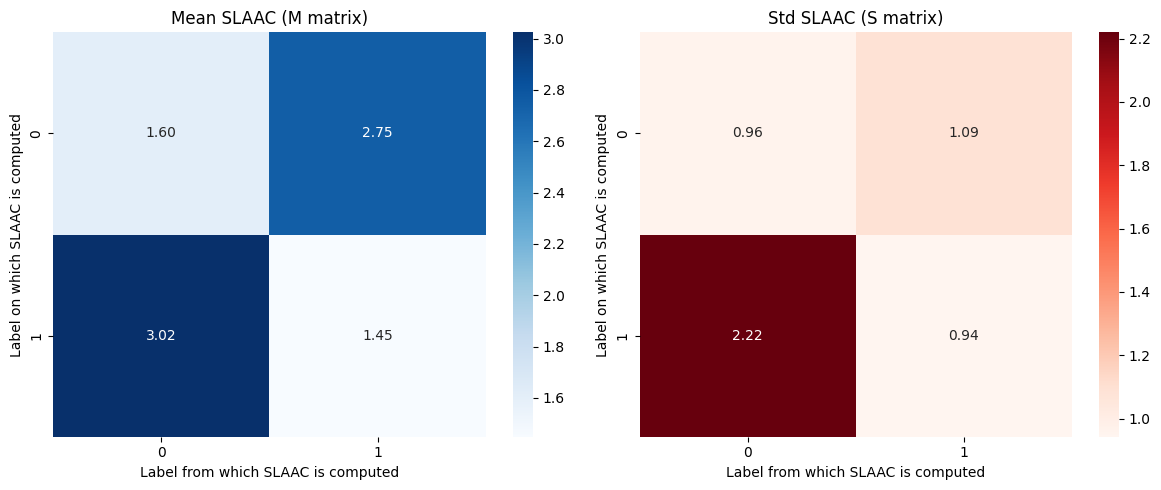

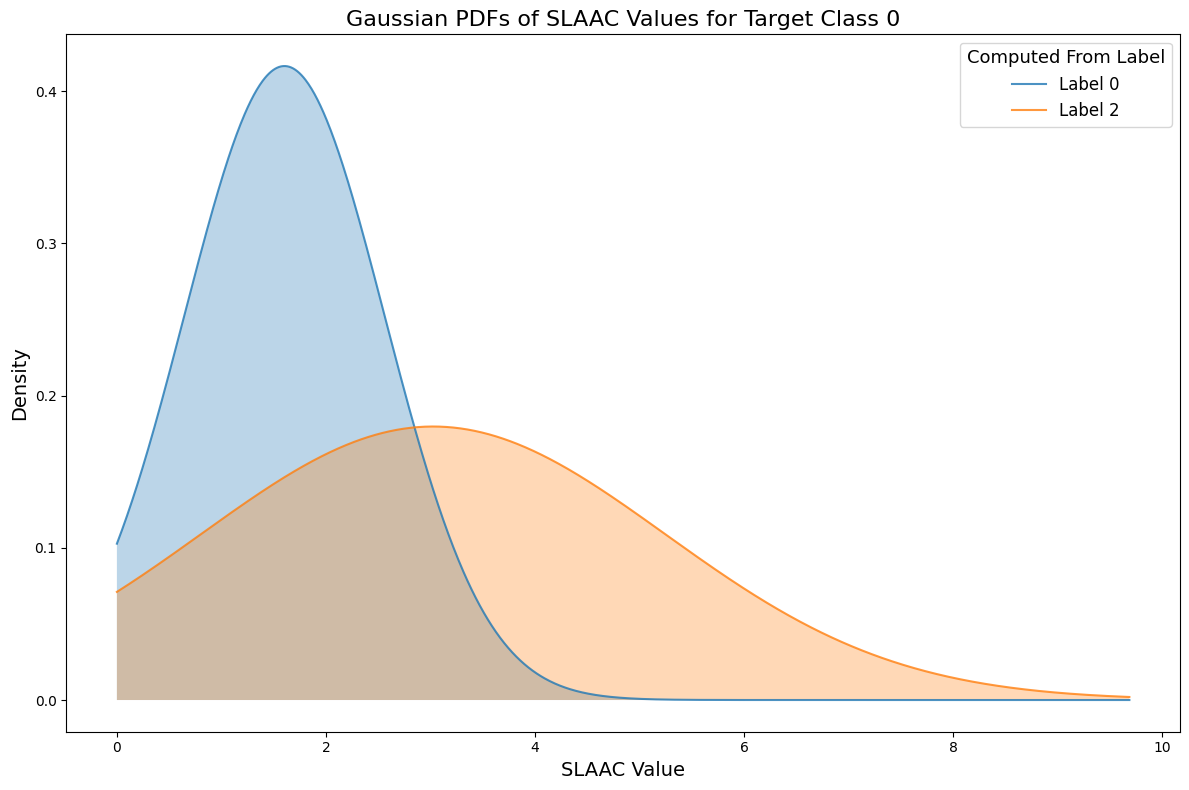


--- Confidence score: 0.3841 ---
[Stage 6] SLARC hypotheses are not met for this dataset. You can set a distribution transform among 'yeo-johnson' or 'quantile' to try to meet the hypotheses, or set 'ignore_SLARC_check=True' to skip this check.


{}

In [53]:
evaluate_cic_models(
    X=X_iot_scaled_2,
    y=y_iot_2,
    models={key: val for key, val in models.items() if "cic" in key and 'SVC' in key}, # just one execution for the matrices
    save_path="cic_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    M = None, S = None, omega_k_dict = omega_k_dict_cic_scaled,
    precomputed_confidence_score=None,
    stop=True,
    name="CICIoT23 (Scaled)"
)


Evaluating model: cic_None
Applying Quantile transform (to normal) to X_train and X_test.
CHECK PASSED: Dataset is valid for the HAR protocol.
No estimator provided. Using LGBMClassifier as default.
Estimator on test set: Accuracy: 0.9997, F1 score: 0.9997
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.


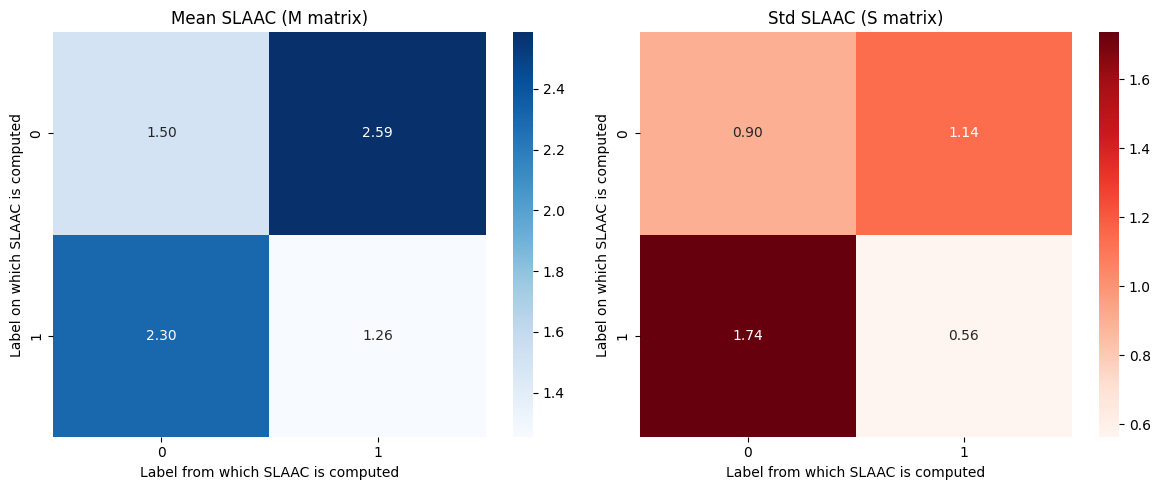

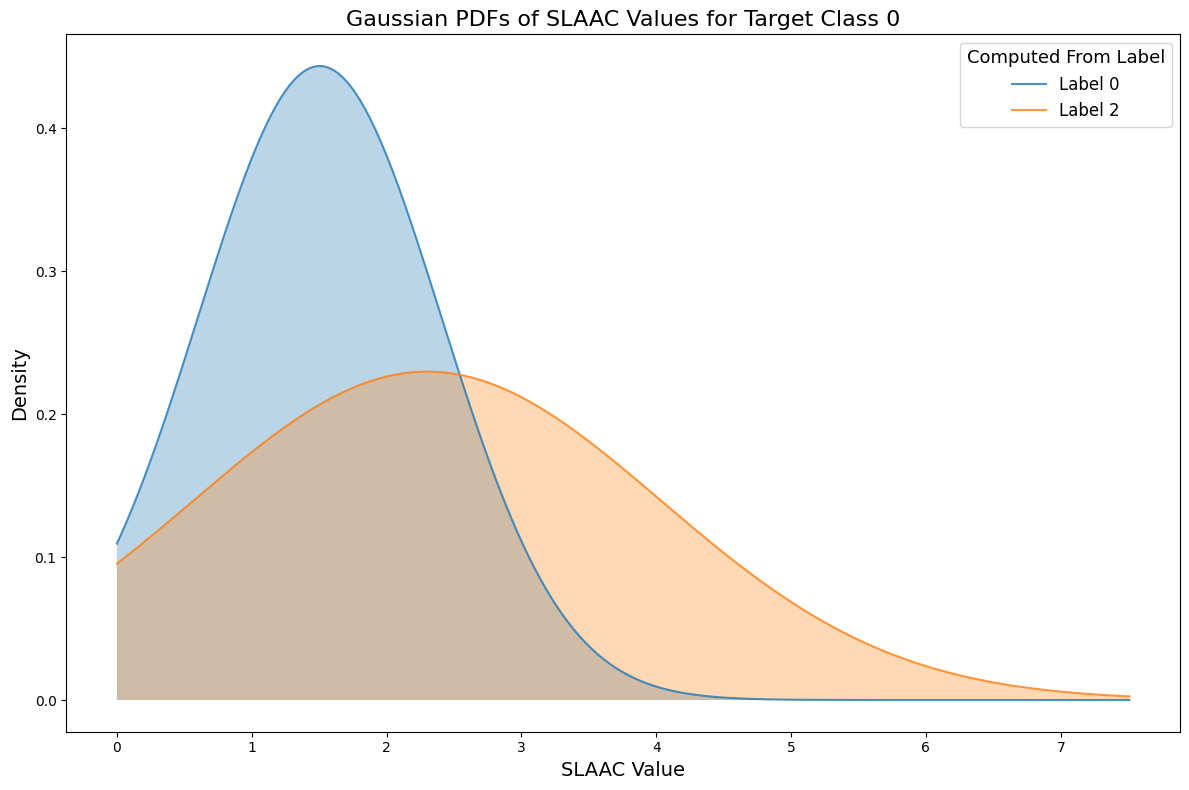


--- Confidence score: 0.3766 ---
[Stage 6] SLARC hypotheses are not met for this dataset. You can set a distribution transform among 'yeo-johnson' or 'quantile' to try to meet the hypotheses, or set 'ignore_SLARC_check=True' to skip this check.


{}

In [60]:
evaluate_cic_models(
    X=X_iot_scaled_2,
    y=y_iot_2,
    models={"cic_None": None}, # default training
    save_path="cic_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    M = None, S = None, omega_k_dict = omega_k_dict_cic_scaled,
    precomputed_confidence_score=None,
    stop=True,
    trans="quantile",
    name="CICIoT23 (Scaled, Quantile)"
)

In [ ]:
cic_results = evaluate_cic_models(
    X=X_iot_2,
    y=y_iot_2,
    models={key: val for key, val in models.items() if "cic" in key},
    save_path="cic_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000
)


Evaluating model: ExtraTreesClassifier_cic
CHECK PASSED: Dataset is valid for the HAR protocol.
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
CHECK PASSED: Weights are valid.

--- Precomputed confidence score: 0.5098 ---
Could not pickle the task to send it to the workers.

Evaluating model: RidgeClassifier_cic
CHECK PASSED: Dataset is valid for the HAR protocol.
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
CHECK PASSED: Weights are valid.

--- Precomputed confidence score: 0.5098 ---

=== HAR protocol results ===
Attacked samples                = 100
Attack success rate (AAcc)      = 0.8800
Adversarial accuracy            = 0.1200
Average likelihood (target)     = 0.4252
Maximum likelihood (target)     = 0.7683
HAR score                       = 0.5058
Results for RidgeClas

In [19]:
X_train_baiot, X_test_baiot, y_train_baiot, y_test_baiot = train_test_split(X_baiot, y_baiot, test_size=0.2, random_state=SEED)

N = 100_000
idx_small = np.random.choice(X_train_baiot.shape[0], N, replace=False)
X_train_baiot_small = X_train_baiot.iloc[idx_small]
y_train_baiot_small = y_train_baiot.iloc[idx_small]
mi = mutual_info_classif(X_train_baiot_small, y_train_baiot_small)
mi = pd.Series(mi, index=X_train_baiot_small.columns)
mi = mi / mi.sum()
omega_k_dict_biot = mi.to_dict()
print(omega_k_dict_biot)

del X_train_baiot, X_test_baiot, y_train_baiot, y_test_baiot, X_train_baiot_small, y_train_baiot_small
gc.collect()

{'MI_dir_L5_weight': 0.08202890172919557, 'MI_dir_L5_mean': 0.10935322904138059, 'MI_dir_L5_variance': 0.07329790716508304, 'H_L5_weight': 0.08217489005533195, 'H_L5_mean': 0.10932177639093418, 'H_L5_variance': 0.07318317300712598, 'HH_L5_weight': 0.04627556235015473, 'HH_L5_mean': 0.05306020734299888, 'HH_L5_std': 0.021233390792000262, 'HH_L5_magnitude': 0.07010343727717992, 'HH_L5_radius': 0.004984094183521104, 'HH_L5_covariance': 0.0007572220297816007, 'HH_L5_pcc': 0.006094614983963005, 'HH_jit_L5_weight': 0.04635604120591621, 'HH_jit_L5_mean': 0.09909572062439519, 'HH_jit_L5_variance': 0.0029651622948652185, 'HpHp_L5_weight': 0.005316219619856273, 'HpHp_L5_mean': 0.04835783654209521, 'HpHp_L5_std': 0.005150826396615032, 'HpHp_L5_magnitude': 0.06023817775675978, 'HpHp_L5_radius': 7.51707501765136e-05, 'HpHp_L5_covariance': 0.0005764384606698124, 'HpHp_L5_pcc': 0.0}


4456

In [20]:
were_slarc_hypotheses_checked_for_nbiot = True
nbiot_confidence_score_no_transform_all = 0.5973
nbiot_confidence_score_no_transform_all_KL = 0.8961
# M matrix (Mean SLAAC)
nbiot_M = np.array([
    [2.17, 1711.60],
    [3.39, 1.50]
])

# Std SLAAC (S matrix)
nbiot_S = np.array([
    [6.95, 2783.41],
    [1.53, 4.54]
])

nbiot_M = nbiot_M.T
nbiot_S = nbiot_S.T


# Remove every element from the nbiot dataset which label is not either 0 or 1
X_baiot = X_baiot.reset_index(drop=True)
y_baiot = y_baiot.reset_index(drop=True)
X_baiot_2 = X_baiot[y_baiot.isin([0, 1])]
y_baiot_2 = y_baiot[y_baiot.isin([0, 1])]

def evaluate_nbiot_models(X, y, models, save_path="nbiot_results", 
                           neighborhood_default_max_iter=1000, 
                           heuristic_max_iter=100, heuristic_patience=100,joblib=True):
    global were_slarc_hypotheses_checked_for_nbiot

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    results_dict = {}

    for model_name, model in models.items():
        if "nbiot" not in model_name:  # Only process nbiot models
            continue

        print(f"\nEvaluating model: {model_name}")
        try:
            results = HAR_protocol(
                X=X,
                y=y,
                target_class=0, # SlowLoris -> Benign
                estimator=model,
                random_state=SEED,
                omega_k_dict=omega_k_dict_biot,
                neighborhood_default_max_iter=neighborhood_default_max_iter,
                heuristic_max_iter=heuristic_max_iter,
                heuristic_patience=heuristic_patience,
                #ignore_SLARC_check=were_slarc_hypotheses_checked_for_nbiot,
                adv_samples=20,
                #distribution_transform='quantile',
                precomputed_confidence_score=nbiot_confidence_score_no_transform_all,
                precomputed_M=nbiot_M,
                precomputed_S=nbiot_S,
                SLARC_check_max_samples=None,
                use_joblib=joblib, # for parallel processing
                debug_mode=False, # Will ignore exceptions during attacks
                verbose=2,
                dataset_name="N-BaIoT",
                final_cost="Likelihood",
                SLARC_check_technique="BC",
                #stop_after_computing_slarc_params=True
            )
        
            if not were_slarc_hypotheses_checked_for_nbiot:
                were_slarc_hypotheses_checked_for_nbiot = True # We only need to check this once

            # Save results to a dictionary

            # Convert the dictionary to a DataFrame for CSV saving
            results_df = pd.DataFrame(
                [results],
                columns=["HAR", "confidence_score", "adversarial_accuracy", "avg_likelihood", "max_likelihood"]
            )

            # Save results to a CSV file for later analysis
            save_filename = os.path.join(save_path, f"{model_name}_{heuristic_max_iter}_results.csv")
            results_df.to_csv(save_filename, index=False)

            print(f"Results for {model_name} saved to {save_filename}.")
        
        except Exception as e:
            raise(e)

    return results_dict

In [21]:
# Train ExtraTrees on N-BaIoT

X_train_baiot, X_test_baiot, y_train_baiot, y_test_baiot = train_test_split(X_baiot, y_baiot, test_size=0.2, random_state=SEED)
extra_trees2 = ExtraTreesClassifier(random_state=SEED)
extra_trees2.fit(X_train_baiot, y_train_baiot)
y_pred = extra_trees2.predict(X_test_baiot)
acc = accuracy_score(y_test_baiot, y_pred)
f1 = f1_score(y_test_baiot, y_pred, average='weighted')
print(f"Dataset: nbiot, Model: ExtraTreesClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

del X_train_baiot, X_test_baiot, y_train_baiot, y_test_baiot

Dataset: nbiot, Model: ExtraTreesClassifier, Accuracy: 1.0000, F1-Score: 1.0000


In [22]:
nbiot_results = evaluate_nbiot_models(
    X=X_baiot_2,
    y=y_baiot_2,
    models={'ExtraTrees_nbiot': extra_trees2},
    save_path="nbiot_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000
)


Evaluating model: ExtraTrees_nbiot
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 1.0000, F1 score: 1.0000
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5973 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 0.5000
Adversarial accuracy            = 0.5000
Average likelihood (target)     = 0.1050
Maximum likelihood (target)     = 0.2438
HAR score                       = 0.4475
Results for ExtraTrees_nbiot saved to nbiot_results\ExtraTrees_nbiot_1000_results.csv.


In [ ]:
nbiot_results = evaluate_nbiot_models(
    X=X_baiot_2,
    y=y_baiot_2,
    models={key: val for key, val in models.items() if "nbiot" in key and ("XGB" in key or "LGBM" in key or "Hist" in key or "Extra" in key)},
    save_path="nbiot_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000
)

The notebook crashed at this point, so we start again from LGBM:

In [15]:
nbiot_results = evaluate_nbiot_models(
    X=X_baiot_2,
    y=y_baiot_2,
    models={"Passive_Aggressive_nbiot": passive_aggressive},
    save_path="nbiot_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    joblib=True
)


Evaluating model: Passive_Aggressive_nbiot
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.4195, F1 score: 0.5632
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5973 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 0.5000
Adversarial accuracy            = 0.5000
Average likelihood (target)     = 0.0979
Maximum likelihood (target)     = 0.2425
HAR score                       = 0.4510
Results for Passive_Aggressive_nbiot saved to nbiot_results\Passive_Aggressive_nbiot_1000_results.csv.


In [16]:
# Train LGBMClassifier on X_baiot
lgbm = LGBMClassifier(random_state=SEED)
lgbm.fit(X_baiot, y_baiot)

# Test
y_pred = lgbm.predict(X_baiot)
acc = accuracy_score(y_baiot, y_pred)
f1 = f1_score(y_baiot, y_pred, average='weighted')
print(f"Dataset: nbiot, Model: LGBMClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4621
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 23
[LightGBM] [Info] Start training from score -3.004813
[LightGBM] [Info] Start training from score -1.149958
[LightGBM] [Info] Start training from score -0.456019
Dataset: nbiot, Model: LGBMClassifier, Accuracy: 1.0000, F1-Score: 1.0000


In [17]:
nbiot_results = evaluate_nbiot_models(
    X=X_baiot_2,
    y=y_baiot_2,
    models={"LGBM_nbiot": lgbm},
    save_path="nbiot_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    joblib=True
)


Evaluating model: LGBM_nbiot
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 1.0000, F1 score: 1.0000
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5973 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 0.6000
Adversarial accuracy            = 0.4000
Average likelihood (target)     = 0.0656
Maximum likelihood (target)     = 0.4311
HAR score                       = 0.5606
Results for LGBM_nbiot saved to nbiot_results\LGBM_nbiot_1000_results.csv.


In [18]:
# Same for HistGradientBoostingClassifier
hist = HistGradientBoostingClassifier(random_state=SEED)
hist.fit(X_baiot, y_baiot)

# Test
y_pred = hist.predict(X_baiot)
acc = accuracy_score(y_baiot, y_pred)
f1 = f1_score(y_baiot, y_pred, average='weighted')
print(f"Dataset: nbiot, Model: HistGradientBoostingClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

Dataset: nbiot, Model: HistGradientBoostingClassifier, Accuracy: 1.0000, F1-Score: 1.0000


In [19]:
nbiot_results = evaluate_nbiot_models(
    X=X_baiot_2,
    y=y_baiot_2,
    models={"Hist_nbiot": hist},
    save_path="nbiot_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    joblib=True
)


Evaluating model: LGBM_nbiot
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 1.0000, F1 score: 1.0000
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5973 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 0.4500
Adversarial accuracy            = 0.5500
Average likelihood (target)     = 0.0438
Maximum likelihood (target)     = 0.2233
HAR score                       = 0.4303
Results for LGBM_nbiot saved to nbiot_results\LGBM_nbiot_1000_results.csv.


In [ ]:
# Train LGBM on CIC dataset and evaluate
lgbm = LGBMClassifier(random_state=SEED, verbose=-1)
lgbm.fit(X_iot, y_iot)

# Test
y_pred = lgbm.predict(X_iot)
acc = accuracy_score(y_iot, y_pred)
f1 = f1_score(y_iot, y_pred, average='weighted')
print(f"Dataset: cic, Model: LGBMClassifier, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

Dataset: mnist, Model: LGBMClassifier, Accuracy: 0.9949, F1-Score: 0.9949


In [29]:
cic_results = evaluate_cic_models(
    X=X_iot_2,
    y=y_iot_2,
    models={"LGBM_cic": lgbm},
    save_path="cic_results",
    neighborhood_default_max_iter=10_000,
    heuristic_max_iter=1_000,
    heuristic_patience=10_000,
    samples=20
)


Evaluating model: LGBM_cic
CHECK PASSED: Dataset is valid for the HAR protocol.
Estimator on test set: Accuracy: 0.9978, F1 score: 0.9986
CHECK PASSED: Estimator is valid.
CHECK PASSED: Constraints basic format is valid.
CHECK PASSED: Neighborhood is valid.
CHECK PASSED: Attacks are valid.
There are 3 attacks in the list.
CHECK PASSED: Weights are valid.
Using precomputed M, S matrices.

--- Precomputed confidence score: 0.5098 ---

== Parallel attack processing with joblib ==


=== HAR protocol results ===
Attacked samples                = 20
Attack success rate (AAcc)      = 1.0000
Adversarial accuracy            = 0.0000
Average likelihood (target)     = 0.4233
Maximum likelihood (target)     = 0.7505
HAR score                       = 0.5767
Results for LGBM_cic saved to cic_results\LGBM_cic_1000_results.csv.
